In [15]:
import os
from PIL import Image
from glob import glob
import numpy as np
import tensorflow as tf
!pip install pydicom
import pydicom
from IPython import display
!pip install xlrd
import xlrd
# check generated positive samples
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import tensorflow as tf
from copy import copy
import matplotlib.colors as colors

In [1]:






def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


# Create a dictionary with features that may be relevant. # create tf.example message
def image_example(each_dicom_path, seg_label, cls_label):
    feature = {
      
        'dicom_path': _bytes_feature(each_dicom_path.encode()),
        'seg_label': _bytes_feature(seg_label.tostring()), 
        'cls_label': _int64_feature(cls_label),
        
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

def make_samples_win(root_folder_path_for_cases, excel_loc, train_or_val, marked_datatype= np.ubyte):
    
    
    # get case_list
    case_list = glob(root_folder_path_for_cases + "*")
    # print("case_list:", case_list)
    print("len of case_list:", len(case_list))
    
    
    # get work_book of excel
    train_wb = xlrd.open_workbook(excel_loc)
    # get train filp colomn
    sheet =  train_wb.sheet_by_index(0)
    print("sheet:", sheet)

    # extract_number_of rows
    print(sheet.nrows)
    
    case_names =  []
    case_flips = []
    for i in range(1, sheet.nrows):
        case_names.append(sheet.cell_value(i, 0))
        case_flips.append(sheet.cell_value(i, 1))

    # convert flip notes into integer 
    print("case_flips:", case_flips)
    case_flips =[int(s) for s in case_flips] 
    print("case_names:", case_names)
    print("case_flips:", case_flips)
    print("len of case data:", len(case_names))
    print("len of flip data:", len(case_flips))

    # check case list
    print("case list len:", len(case_list))
    assert len(case_names) ==  len(case_flips), " len of cases names does not macthed with flip len in train excel "
    assert len(case_list) ==  len(case_names), " len of cases in the train folder not macthed with cases in train excel "

    my_positive_exmaple ={}
    my_negative_exmaple={}
    
    for case_index, each_case in enumerate(case_list):
        print(each_case)
        # get case name from case list:
        each_case_str = os.path.split(each_case) 
        print("each_case_str:", each_case_str)
        case_name =  each_case_str[-1]
        print("case name:", case_name)
        print("case index:", i, "case name:", case_names[case_index])
        # check case name match or not
        assert case_name ==  case_names[case_index]

        # read_labels for specified case name
        raw_files = glob(each_case + "/*.raw")
        dicom_files = glob(each_case + "/*.DCM")
        # get label path
        for each_path in raw_files:
            if "marked" in each_path:
                label_path =  each_path
        print("label path:", label_path)
        # read labels
        labels = np.fromfile(label_path, dtype = marked_datatype)
        reshaped_labels =  labels.reshape([-1, 512, 512])
        print("reshape labels shape:", reshaped_labels.shape)
        print("len of dicoms in this case:", len(dicom_files))
        assert  reshaped_labels.shape[0] ==  len(dicom_files)  , 'len of dicoms is not equal to the raw label values'

       # check whether needs to flip the label
        if case_flips[case_index] ==1: # flip the enitre label
            train_final_case_labels = np.flip(reshaped_labels, 0)
        else: 
            train_final_case_labels =  reshaped_labels

        None_zero_label_index = []
        # read inputs
        for dicom_index, each_dicom in enumerate(dicom_files):
            path_split = os.path.split(each_dicom)
            print(path_split)
            file_name =  path_split[-1]
            print(file_name)
            
           
            each_slice_label =  train_final_case_labels[dicom_index]
            # count non_zeros value from the each slice label
            num_nonzero = np.count_nonzero(each_slice_label)
            
            if train_or_val == "train":
                each_dicom =  "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\train/" + case_name +"/" +file_name
            else:
                each_dicom =  "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/" + case_name+ "/" +file_name
            
            if num_nonzero > 10:  # only consider the # of nonzeros values >10 to be the positive labels
                each_slice_cls_label = 1
                print("num_nonzero:", num_nonzero)
                None_zero_label_index.append(dicom_index+1)
                print("each_slice_label shape:", each_slice_label.shape)
                print("each_slice label range before binarization: [{}, {}]".format(each_slice_label.min(), each_slice_label.max()))

                # binarize the mask label
                each_slice_label[each_slice_label> 0] = 255
                print("each_slice label range before after binarization: [{}, {}]".format(each_slice_label.min(), each_slice_label.max()))

                # genrate positive examples
                my_positive_exmaple[each_dicom]=(each_slice_label, each_slice_cls_label)

            else: # negative examples
                each_slice_cls_label = 0
                my_negative_exmaple[each_dicom]=(each_slice_label, each_slice_cls_label)

            if dicom_index % 20 == 0:
                    display.clear_output(wait=True)  

            if dicom_index == len(dicom_files)-1:
                print("total " + str(len(dicom_files)) + " checked ---------------------------------------------------------------------------->")

   
        # check the length for each case
        print("generate positive {} positive samples at currently case step:".format(len(my_positive_exmaple)))
        print("generate positive {} negative samples at currently case step:".format(len(my_negative_exmaple)))   
    return my_positive_exmaple, my_negative_exmaple



def Make_TFRecords(feature_samples_dict, file_name):
    # start to write 
    print("writing tfrecords....")
    count_display = 0
    # strat to write postive train dicoms
    with tf.io.TFRecordWriter(file_name) as writer:
        for dicom_path, labels in feature_samples_dict.items():
            print("dicom_path:", dicom_path)
    #         dicom_path_string = open(dicom_path, 'rb').read()
            seg_label = labels[0]
            print(seg_label.shape)
            cls_label = labels[1]
            tf_example = image_example(dicom_path, seg_label, cls_label)  # need image_example function to genearte mesage for writing tf records
            writer.write(tf_example.SerializeToString())
            count_display+=1
            if count_display >20:
                display.clear_output(wait=True)  
    print("Generation of TFRecords is finished.")
    
    

## Generate Train TFRECORDS

In [ ]:
# for train
train_root_folder_path_for_cases= "E:/dataset/Leisang/myTry/BleedingDataDCM/train/"
# ## Make into functions for genrerate tf records
train_positive_file_name =  "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/train_positive_samples_win.tfrecords"
train_negative_file_name =  'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/train_negative_samples_win.tfrecords'
# give the location of the file
train_excel_loc = "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/TrainfilpOrNot.xlsx"


# make positive and negative samples:

train_positive_samples, train_negative_samples = make_samples_win(root_folder_path_for_cases=train_root_folder_path_for_cases,
                                                              excel_loc = train_excel_loc,
                                                                    train_or_val="train")


In [ ]:
# make train_positive
Make_TFRecords(feature_samples_dict=train_positive_samples, file_name=train_positive_file_name)

In [ ]:
# make train_negative
Make_TFRecords(feature_samples_dict=train_negative_samples, file_name=train_negative_file_name)

In [ ]:


train_positive_dataset = tf.data.TFRecordDataset(train_positive_file_name)
train_negative_dataset = tf.data.TFRecordDataset(train_negative_file_name)
# Create a dictionary describing the features.
image_feature_description = {
        'dicom_path': tf.io.FixedLenFeature([], tf.string),
        'seg_label': tf.io.FixedLenFeature([], tf.string), 
        'cls_label': tf.io.FixedLenFeature([], tf.int64),
}


def _parse_image_function(example_proto):
    parsed_features = tf.io.parse_single_example(example_proto, image_feature_description)
    # Parse the input tf.Example proto using the dictionary above.
    
    
    # decode dicom
    dicom_path = parsed_features["dicom_path"]
    image_bytes = tf.io.read_file(dicom_path)
    input_image = tf.cast(tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16), tf.float32)
    # decode mask
    seg_label = tf.io.decode_raw(parsed_features['seg_label'], tf.uint8)
    return dicom_path, input_image, seg_label,  parsed_features["cls_label"]


parsed_train_positive_dataset = train_positive_dataset.map(_parse_image_function)
parsed_train_negative_dataset = train_negative_dataset.map(_parse_image_function)

def truncate(x, min, max):
#     print(x.shape)
    cliped =  tf.clip_by_value(x, min, max)
    return cliped
 
def norm(x, min, max):
    # normalize_value = (value − min_value) / (max_value − min_value)
    tensor = tf.math.divide(tf.subtract(x, min),
                    tf.subtract(max, min))
    return tensor

def linear_normalization(input, min=30720.0, max=34816.0):
    truncated_input = truncate(input, min, max)
    norm_input = norm(truncated_input, min, max )
    return  norm_input

def check_dataset(dataset):
    # window the input
    def winwise(input,LB,HB):
        # 20 ,380 for range (-32768, 32767)
        # for tf input , (0, 65535)-? LB =  32788, 33148
        input[input<LB] = LB # low boundary , if < LW , set to LW
        input[input>HB] = HB # high boundary, if > Hw, Set to 255
        return input

    # print(len(parsed_train_positive_dataset))
    BUFFER_SIZE =512
    # random shuffle the train positive dagtaset
    parsed_dataset = dataset.shuffle(BUFFER_SIZE)
    
    palette = copy(plt.cm.gray)
    palette.set_over('r', 1.0)
#     palette.set_under('g', 1.0)
#     palette.set_bad('b', 1.0)
        
    
    
    for image_features in parsed_dataset.take(10):
        dicom_path =  image_features[0]
        input =  image_features[1]
    #     dicom_path = image_features[0].numpy()
        target = image_features[2]
        cls_label = image_features[3]
        print("dicom_path:", dicom_path)
        print("input_image.shape", input.shape)
    #     print("dicom_path", dicom_path)
    #     print("dicom_path:", dicom_path)
        print("seg_label", target.shape)
        print("cls_label", cls_label)

        # reshape label 
        target =  tf.reshape(target, input.shape)
        fig, axes = plt.subplots(1,2, figsize=(20,20))

        #
        
        mask =  np.squeeze(target.numpy())
        norm_mask =mask/255
        input_arr = np.squeeze(winwise(input.numpy(), 32788,33148 ))
        norm_input = linear_normalization(input_arr)
        masked_in = norm_mask + norm_input
        print('masked_in range:[{}, {}]'.format((masked_in.numpy().min()), masked_in.numpy().max()))
        
        masked = np.ma.masked_where(norm_mask==0, masked_in)  # this is only generated mask
        print('masked range:[{}, {}]'.format(masked.min(), masked.max())) 
        print()
        axes[0].imshow(norm_input, cmap='gray')
        axes[0].set_title('input range:[{}, {}]'.format((norm_input.numpy().min()), np.max(norm_input.numpy())))
        axes[1].imshow(norm_mask, cmap='gray')
        axes[1].set_title('target range:[{}, {}]'.format(np.min(norm_mask), np.max(norm_mask)))
        
        fig2, axes2 = plt.subplots(1,1, figsize=(20,20))
        axes2.imshow(norm_input, cmap='gray')
        axes2.imshow(masked, palette, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
        axes2.set_title('target range:[{}, {}]'.format(np.min(masked), np.max(masked)) + dicom_path)
        
        print(dicom_path)

        
check_dataset(parsed_train_positive_dataset)
# check_dataset(parsed_train_negative_dataset)

## Generate Val TFRECORDS

In [4]:
# for val
val_root_folder_path_for_cases= "E:/dataset/Leisang/myTry/BleedingDataDCM/val/"
# ## Make into functions for genrerate tf records
val_positive_file_name =  "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/val_positive_samples_win.tfrecords"
val_negative_file_name =  'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/val_negative_samples_win.tfrecords'
# give the location of the file
val_excel_loc = "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/valfilpOrNot.xlsx"


# make positive and negative samples:

val_positive_samples, val_negative_samples = make_samples_win(root_folder_path_for_cases=val_root_folder_path_for_cases,
                                                              excel_loc = val_excel_loc,
                                                                    train_or_val="val")

('E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-053_001', '00002102.DCM')
00002102.DCM
('E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-053_001', '00002103.DCM')
00002103.DCM
('E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-053_001', '00002104.DCM')
00002104.DCM
('E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-053_001', '00002105.DCM')
00002105.DCM
('E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-053_001', '00002106.DCM')
00002106.DCM
('E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-053_001', '00002107.DCM')
00002107.DCM
('E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-053_001', '00002108.DCM')
00002108.DCM
('E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-053_001', '00002109.DCM')
00002109.DCM
('E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-053_001', '00002110.DCM')
00002110.DCM
('E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-053_001', '00002111.DCM')
00002111.DCM
('E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-053_001', '00002112.DCM')
00002112.DCM
('E:/datas

In [5]:
# make val_positive
Make_TFRecords(feature_samples_dict=val_positive_samples, file_name=val_positive_file_name)

Generation of TFRecords is finished.


In [6]:
# make val_positive
Make_TFRecords(feature_samples_dict=val_negative_samples, file_name=val_negative_file_name)

Generation of TFRecords is finished.


dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-051_001/00000047.DCM', shape=(), dtype=string)
input_image.shape (1, 512, 512, 1)
seg_label (262144,)
cls_label tf.Tensor(1, shape=(), dtype=int64)
masked_in range:[0.5048828125, 1.528076171875]
masked range:[1.513671875, 1.528076171875]

tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-051_001/00000047.DCM', shape=(), dtype=string)
dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000991.DCM', shape=(), dtype=string)
input_image.shape (1, 512, 512, 1)
seg_label (262144,)
cls_label tf.Tensor(1, shape=(), dtype=int64)
masked_in range:[0.5048828125, 1.5390625]
masked range:[1.523193359375, 1.5390625]

tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000991.DCM', shape=(), dtype=string)
dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000989.DCM', shape=(), dtype=string)
input_image.shape (1, 512, 

E:\Projects\Intepreters\Anaconda\envs\TF21\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
E:\Projects\Intepreters\Anaconda\envs\TF21\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000448.DCM', shape=(), dtype=string)
dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000381.DCM', shape=(), dtype=string)
input_image.shape (1, 512, 512, 1)
seg_label (262144,)
cls_label tf.Tensor(0, shape=(), dtype=int64)
masked_in range:[0.5048828125, 0.5927734375]
masked range:[0.0, 0.0]

tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000381.DCM', shape=(), dtype=string)
dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000210.DCM', shape=(), dtype=string)
input_image.shape (1, 512, 512, 1)
seg_label (262144,)
cls_label tf.Tensor(0, shape=(), dtype=int64)
masked_in range:[0.5048828125, 0.5927734375]
masked range:[0.0, 0.0]

tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/ZA-049_001/00000210.DCM', shape=(), dtype=string)
dicom_path: tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\val/

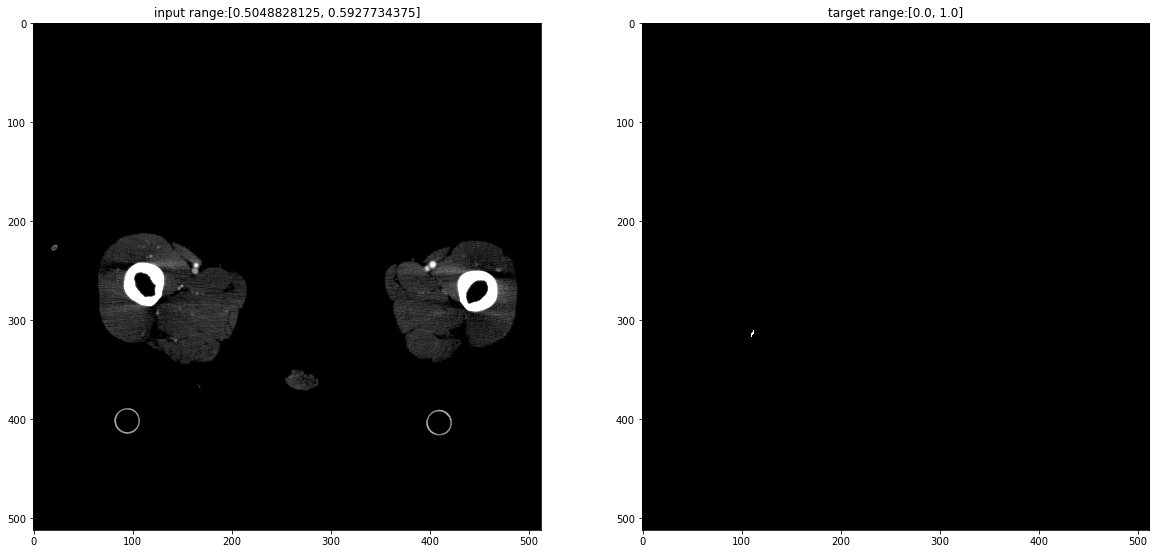

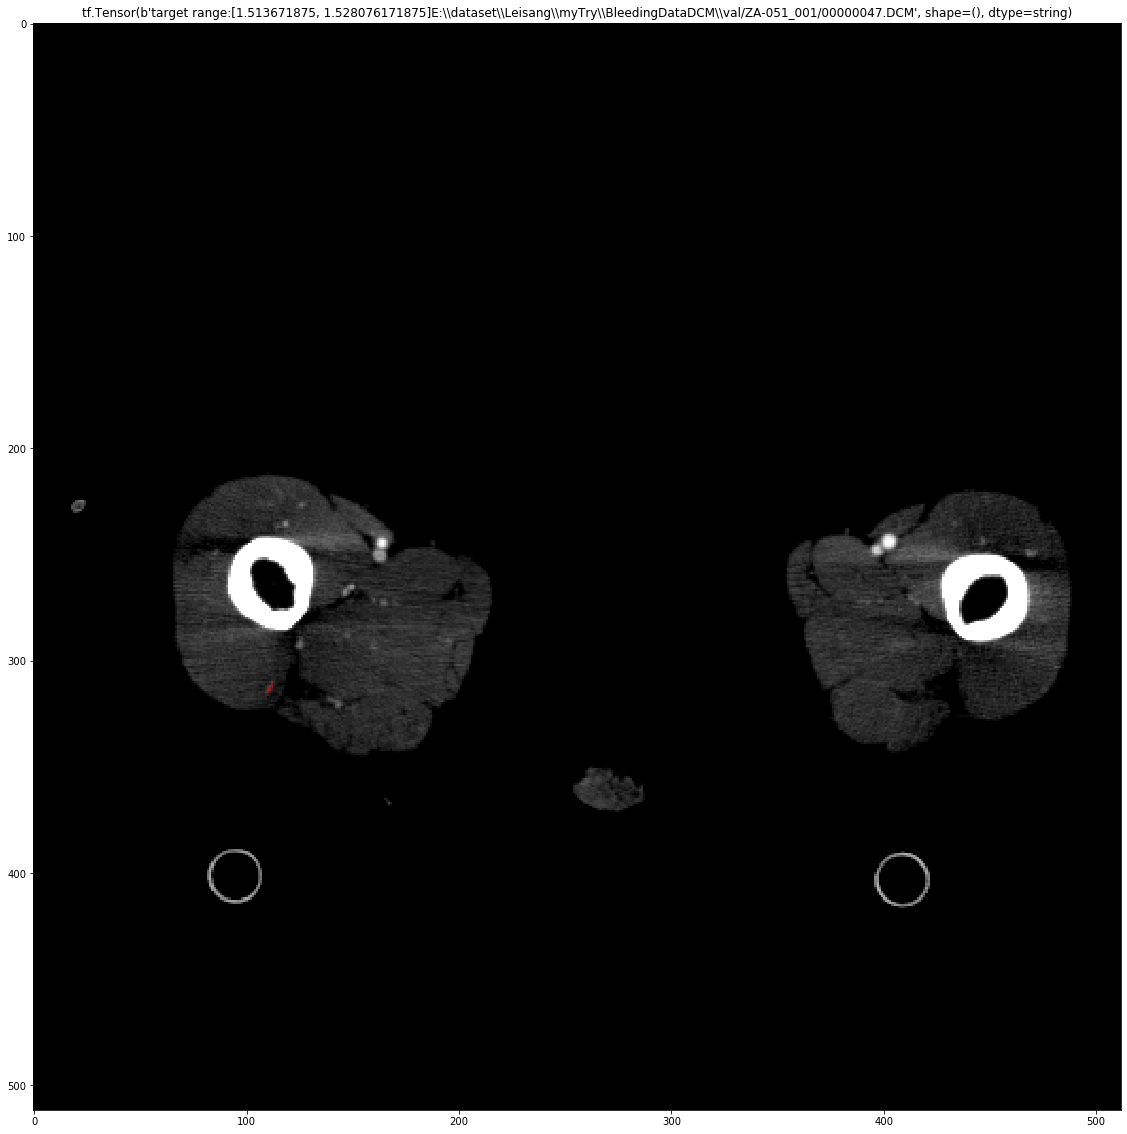

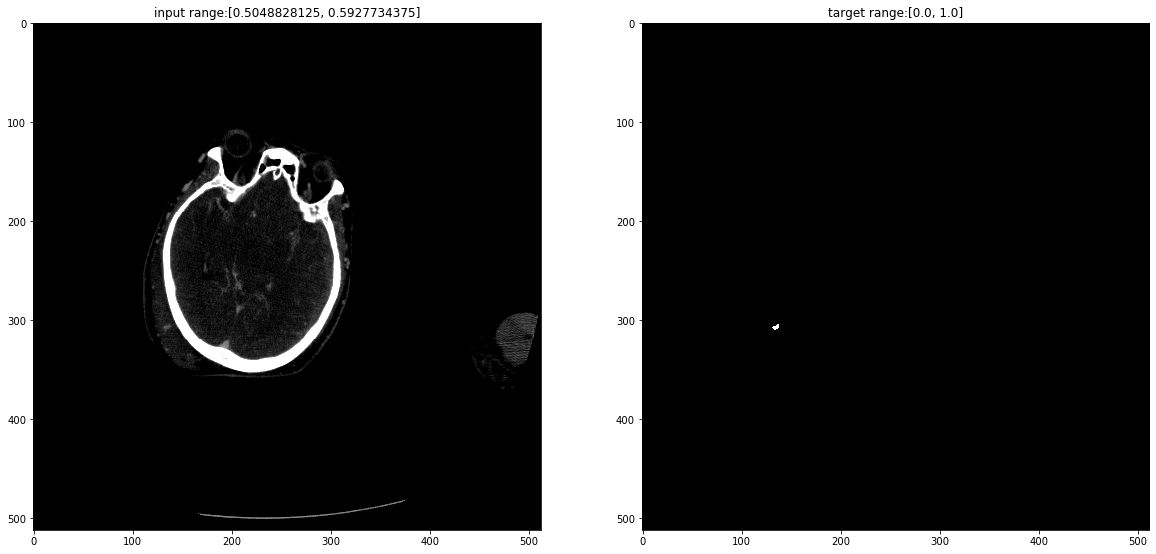

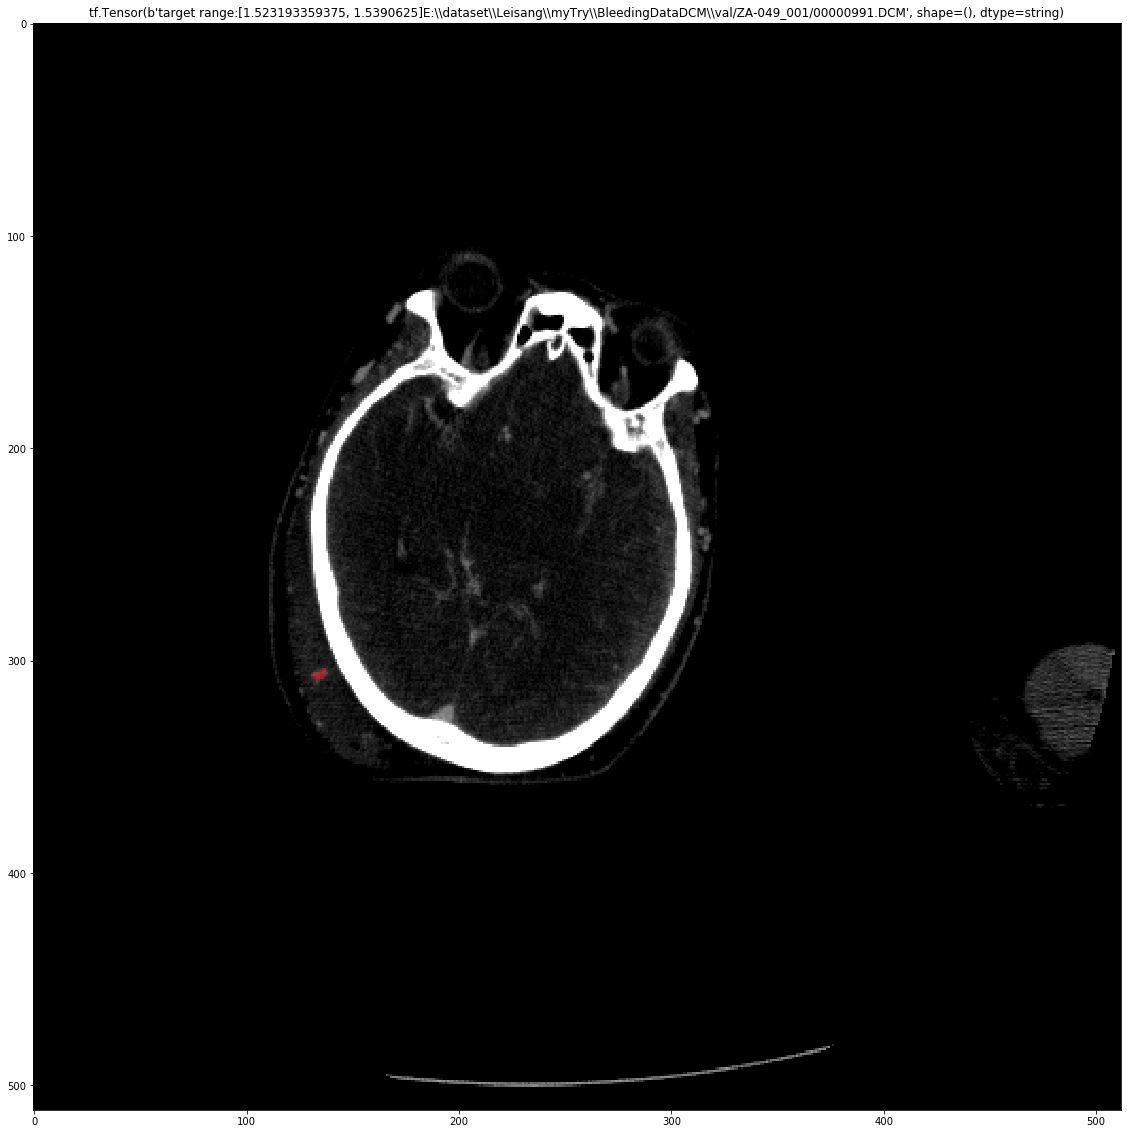

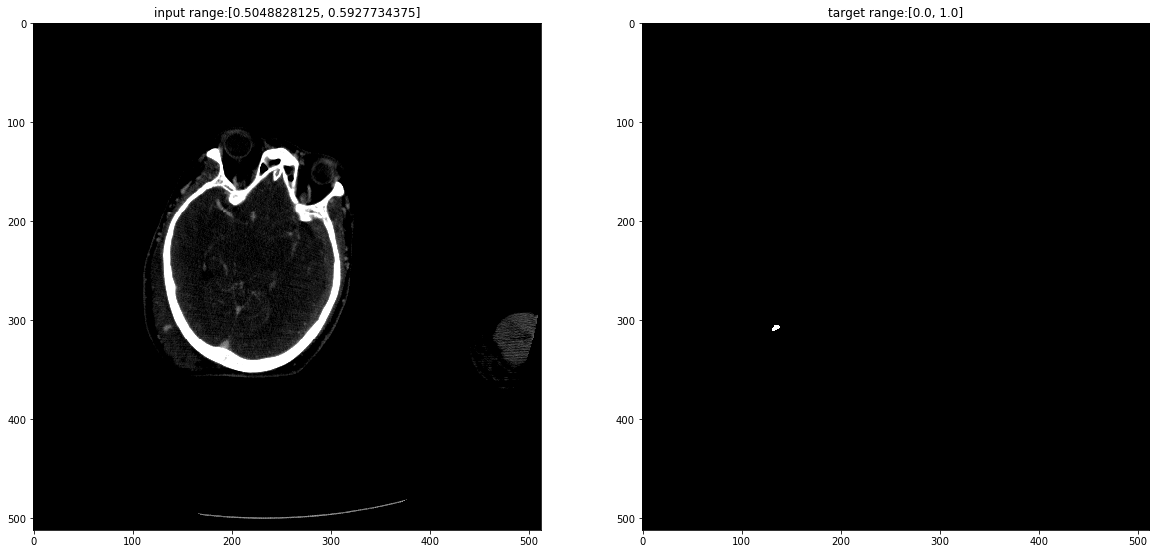

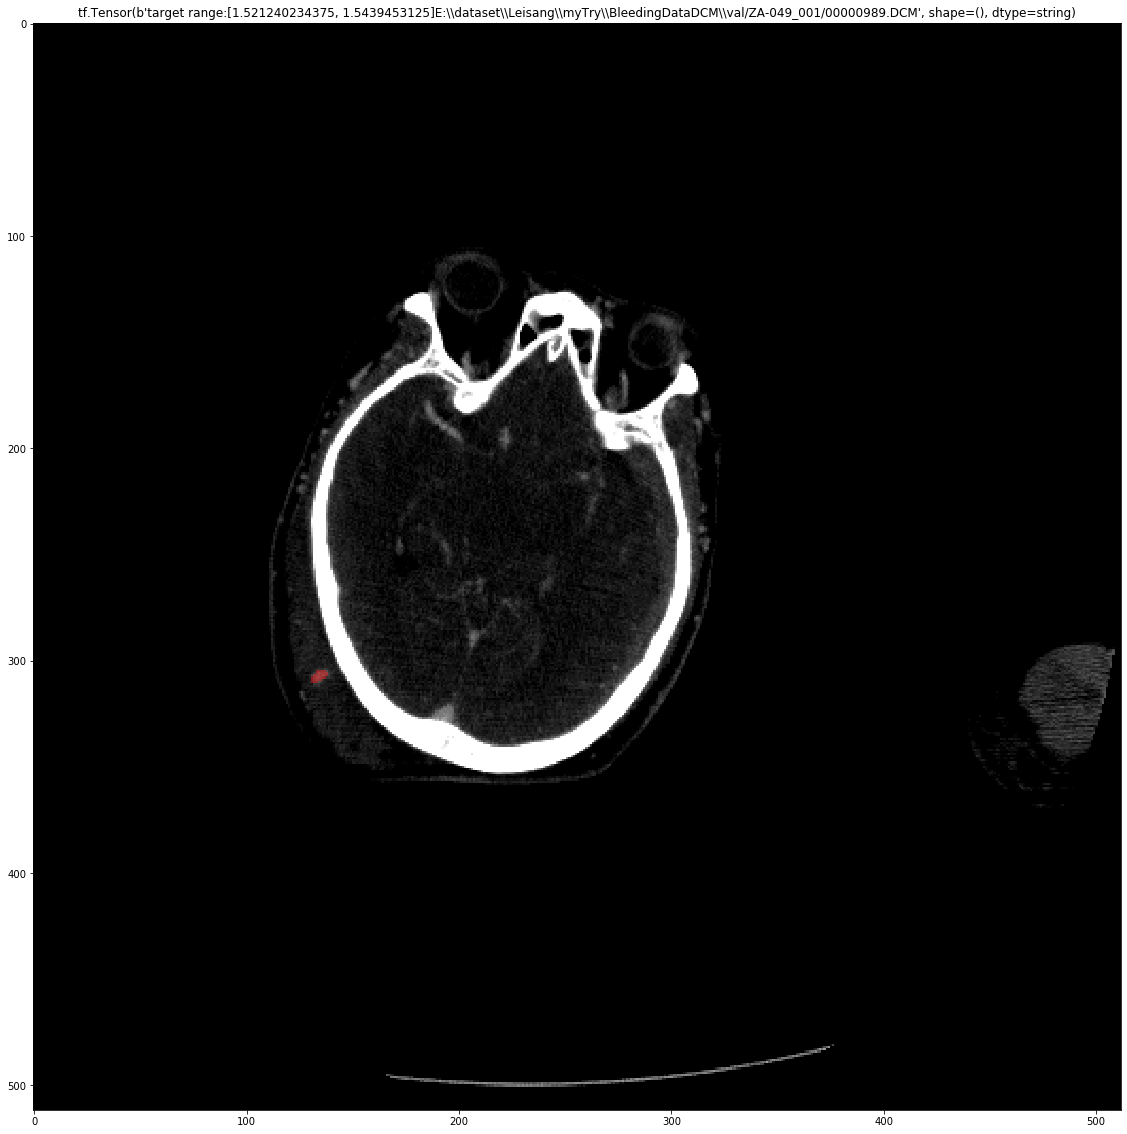

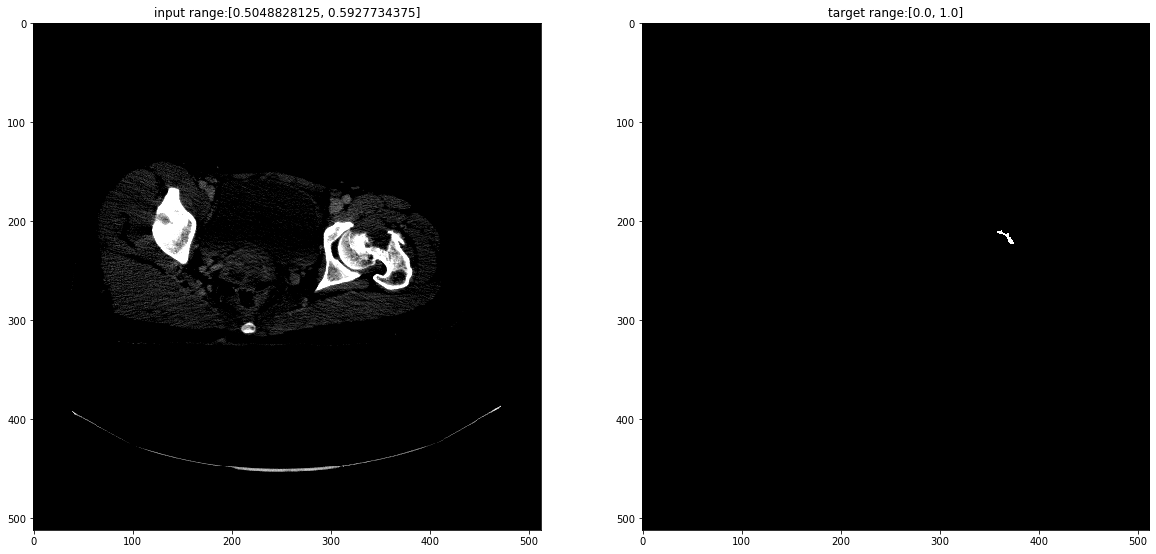

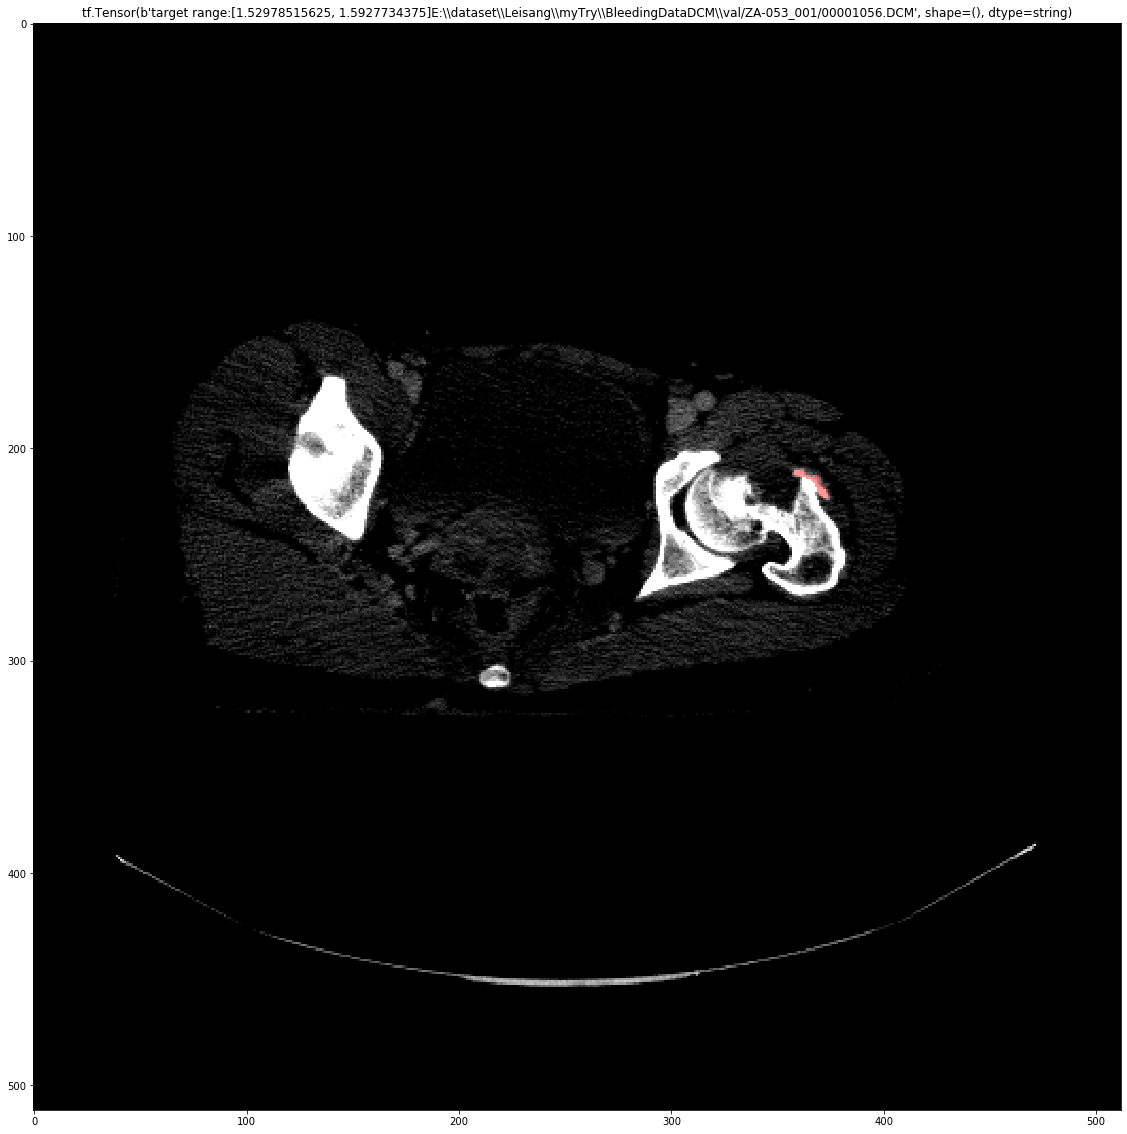

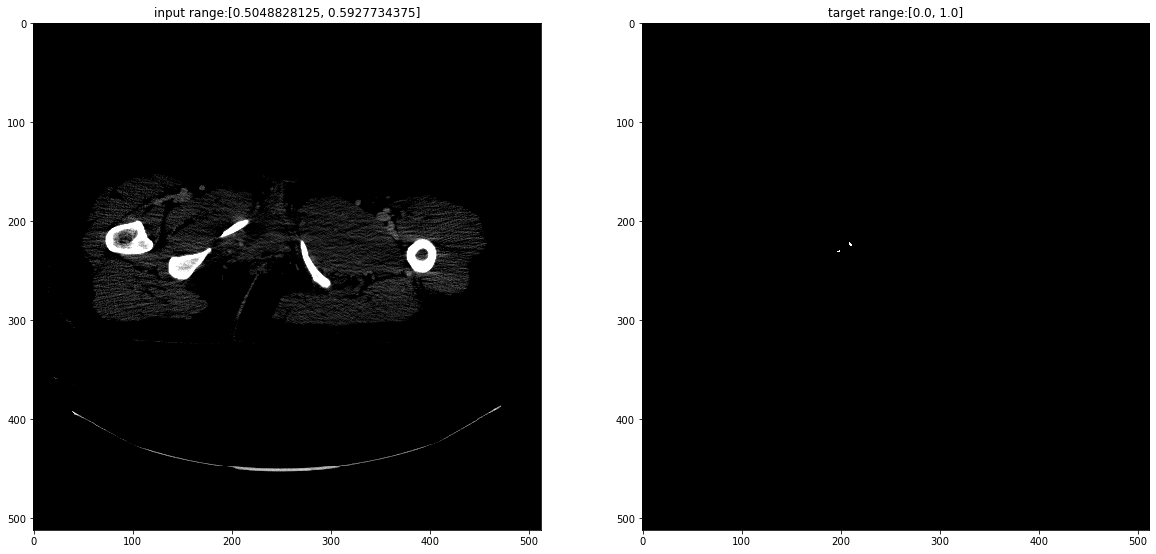

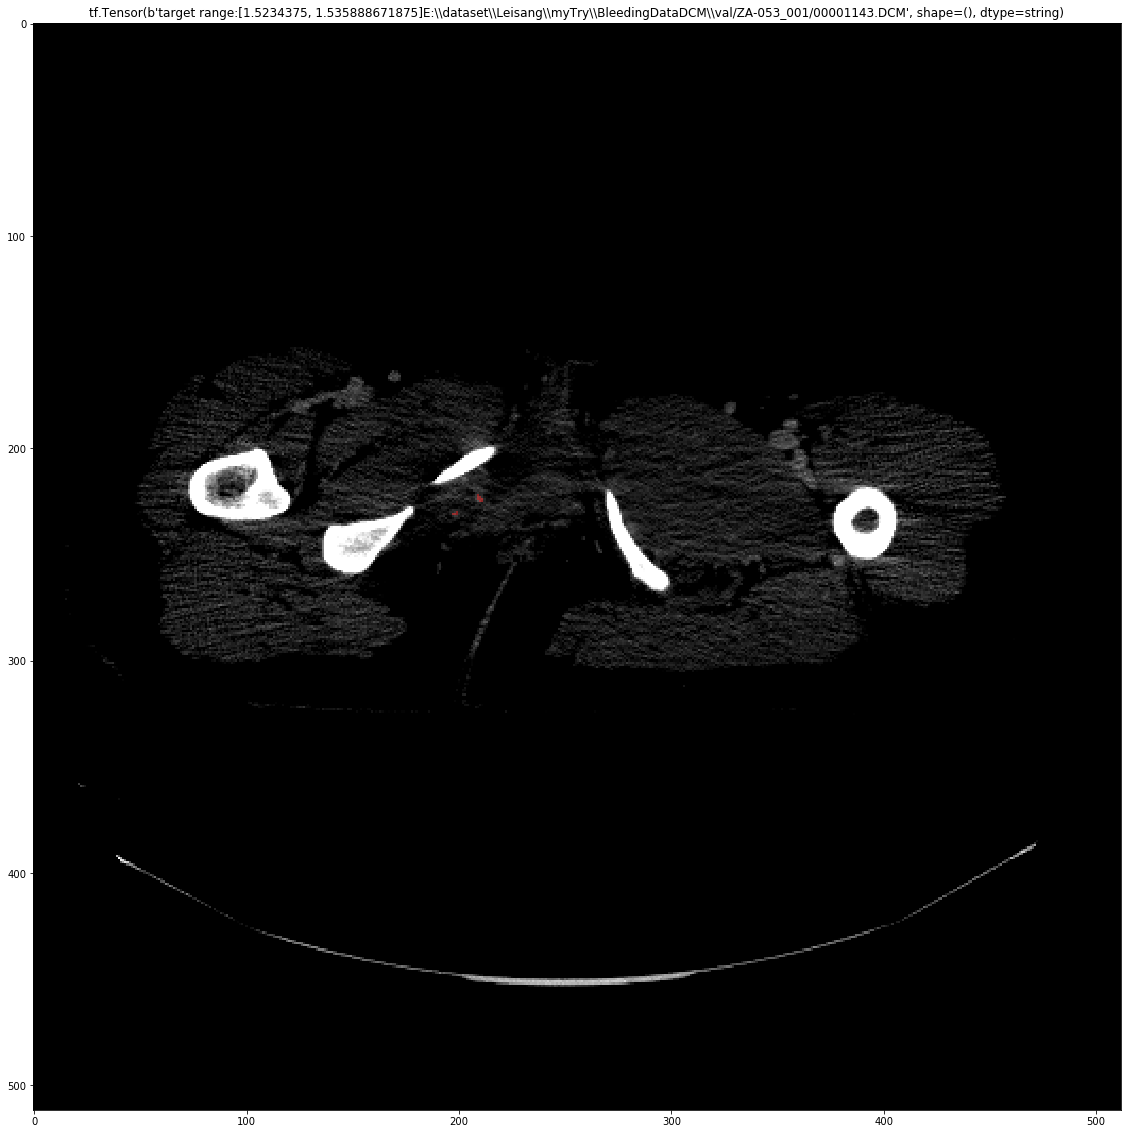

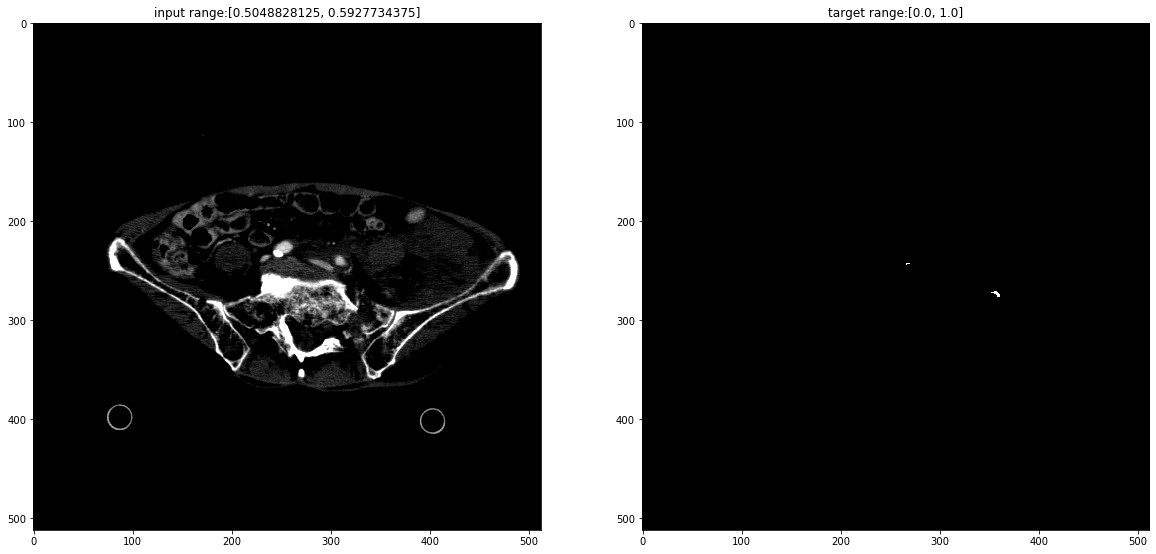

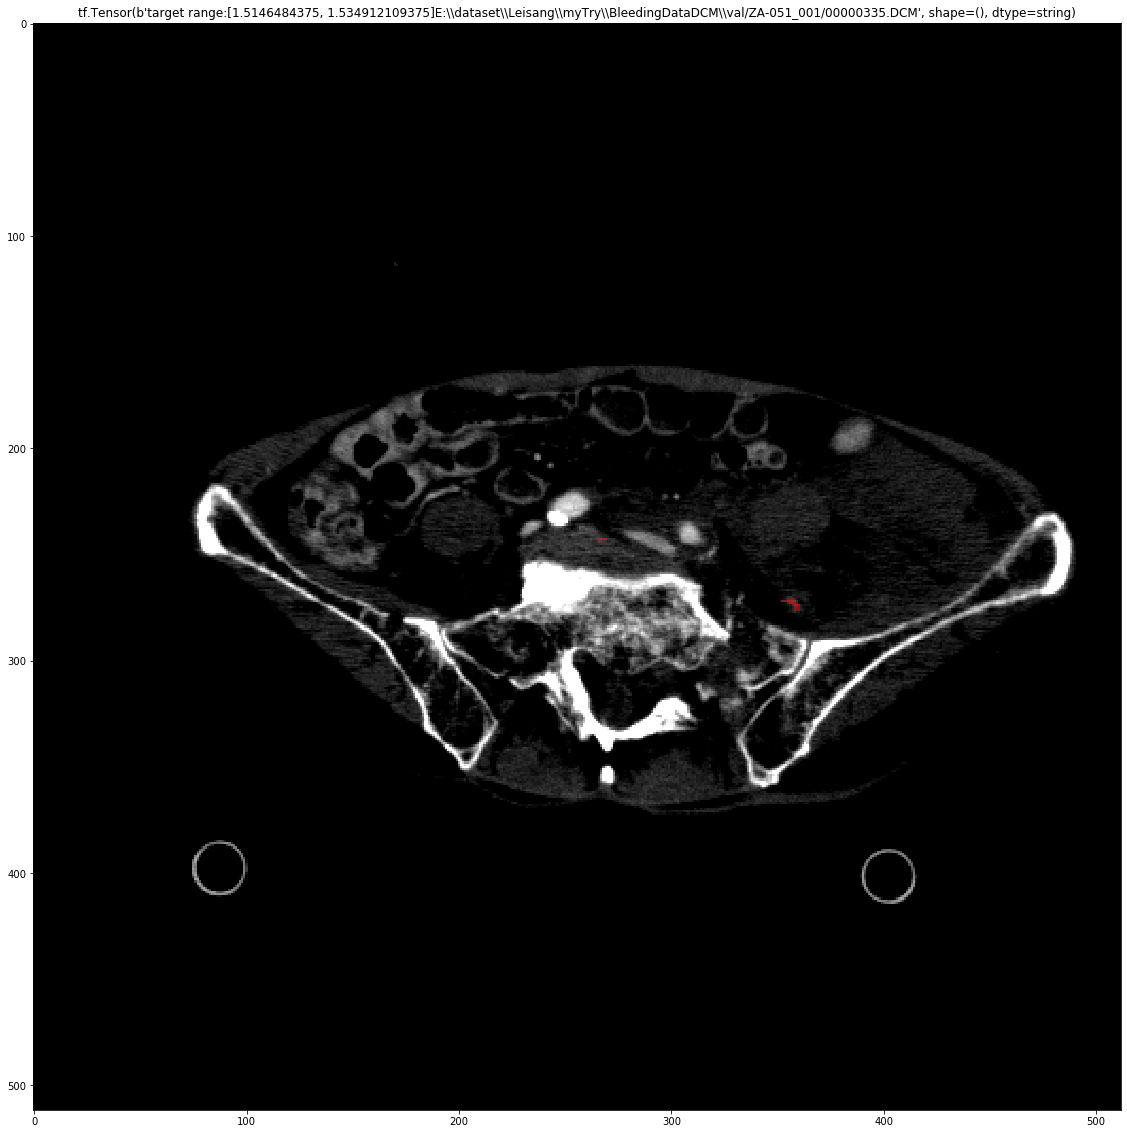

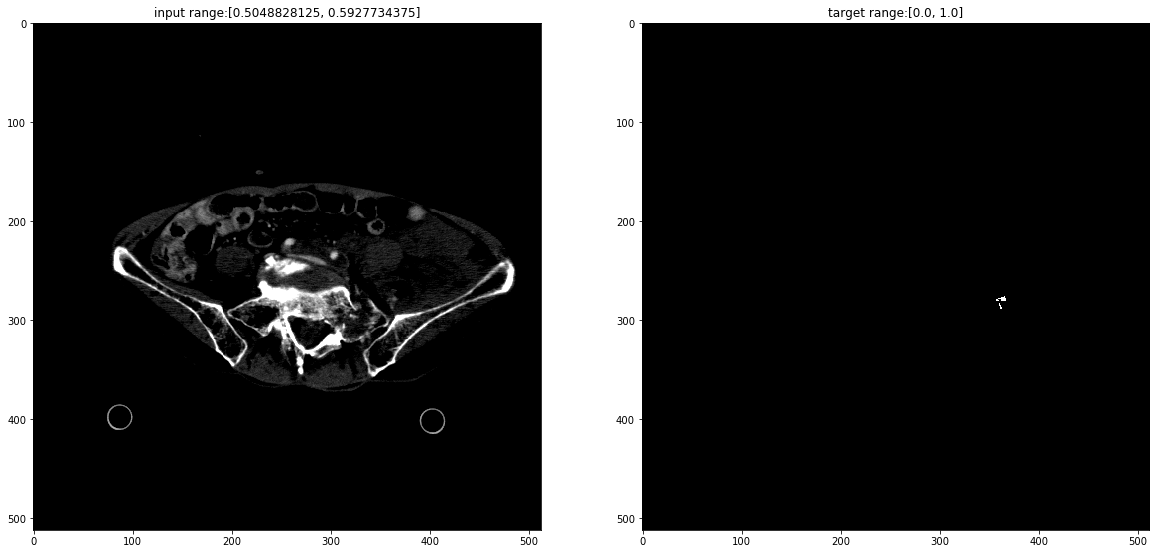

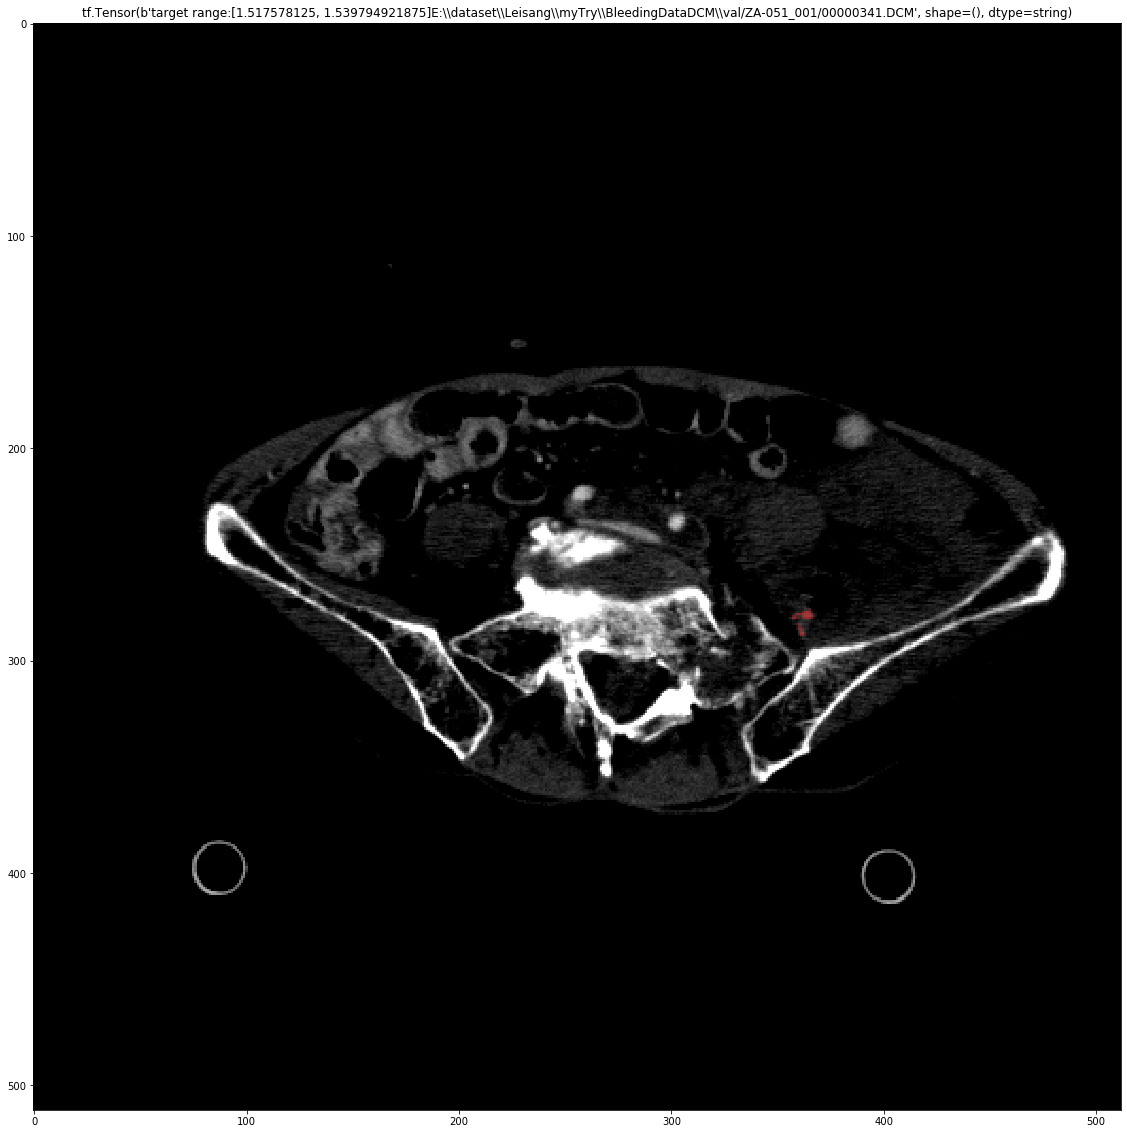

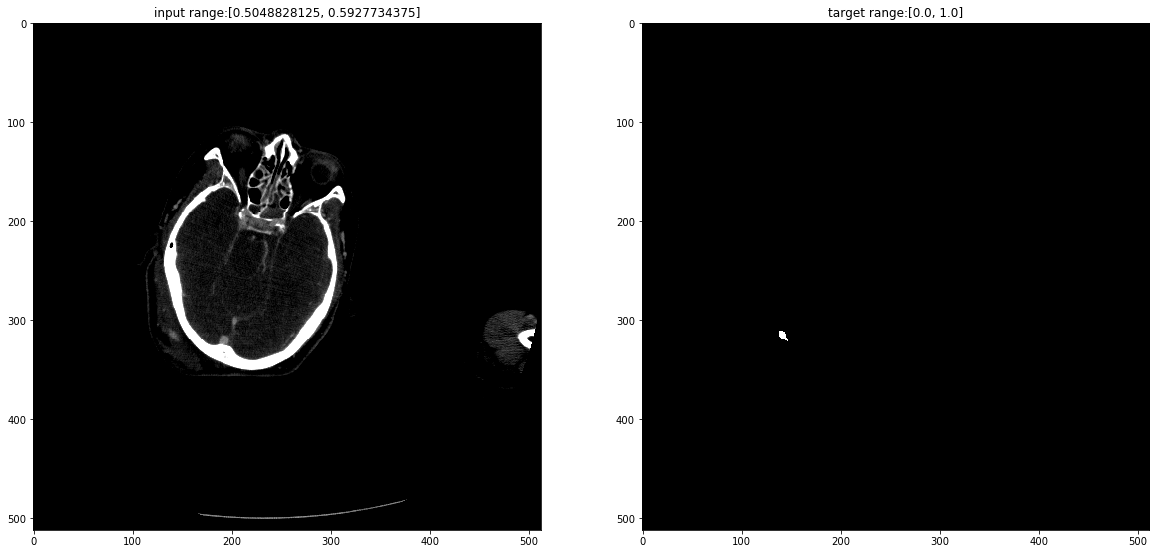

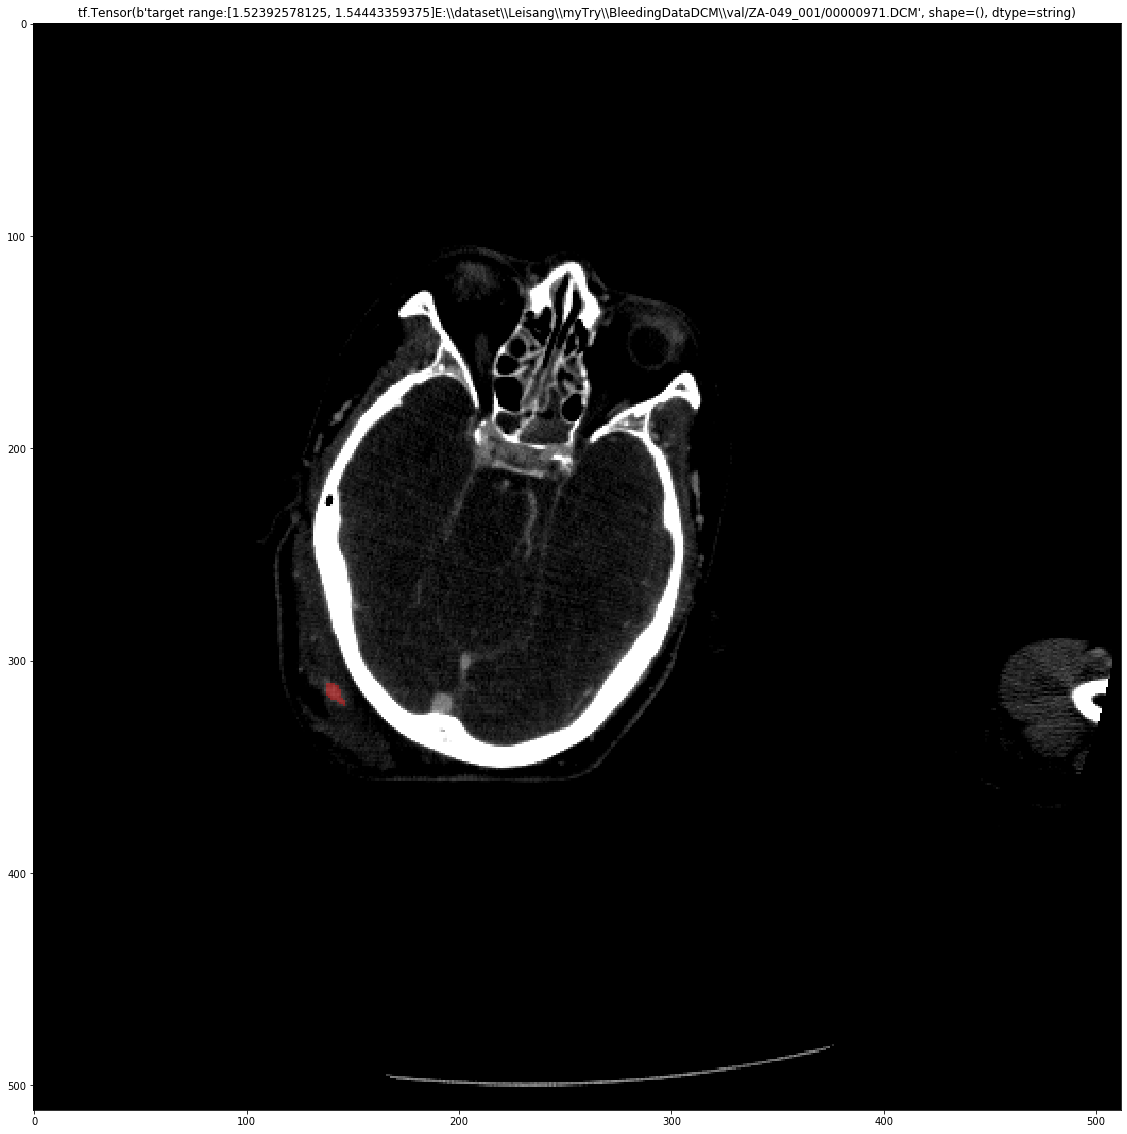

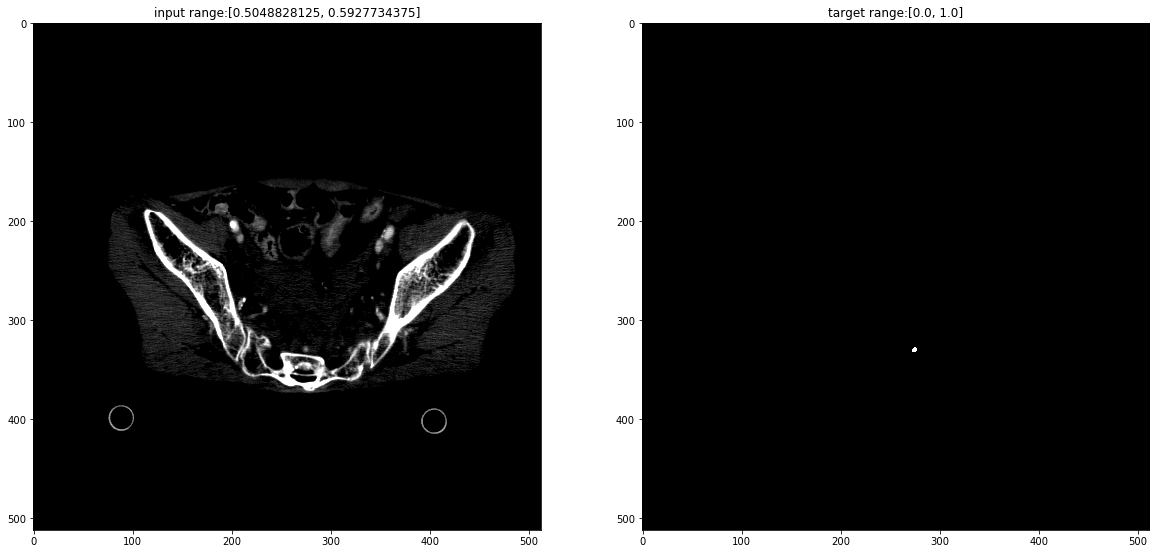

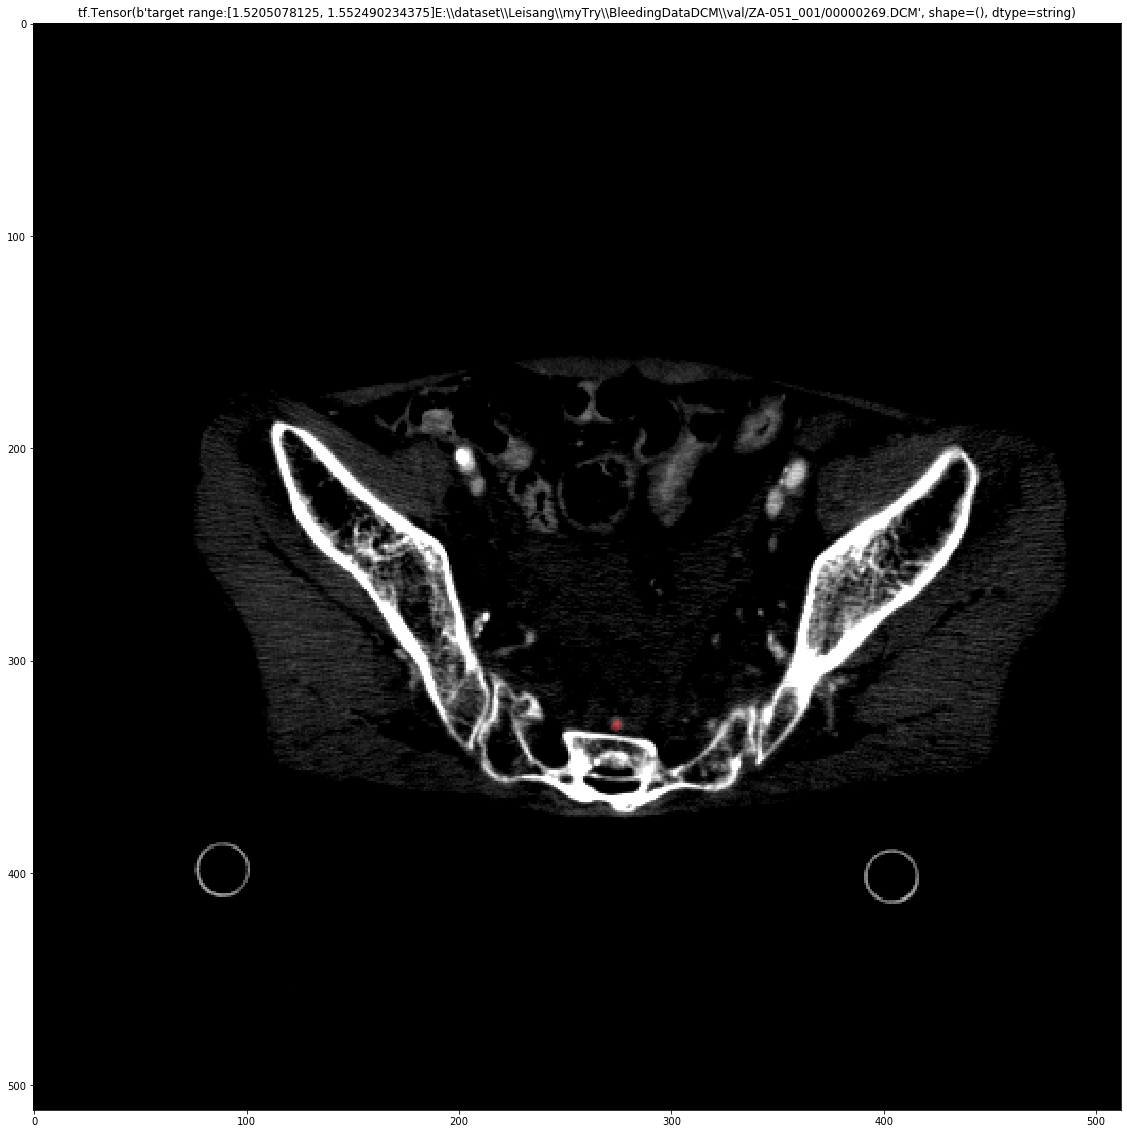

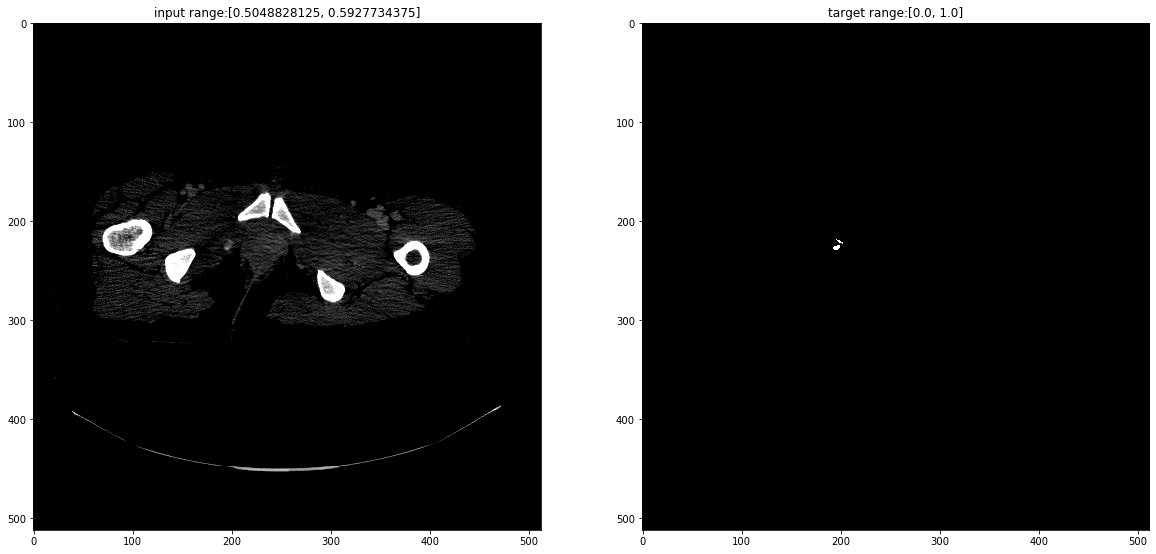

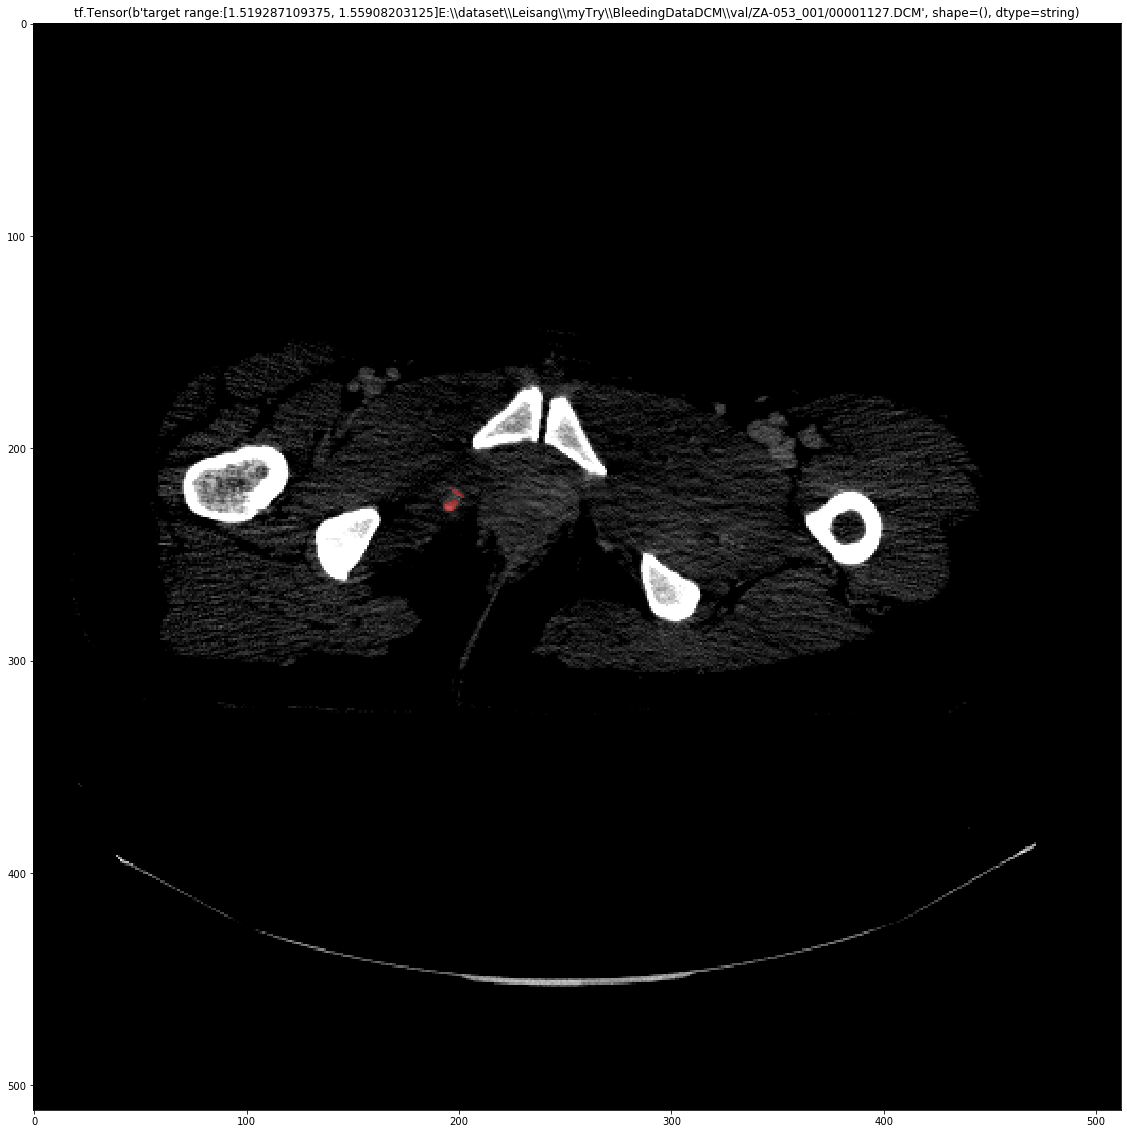

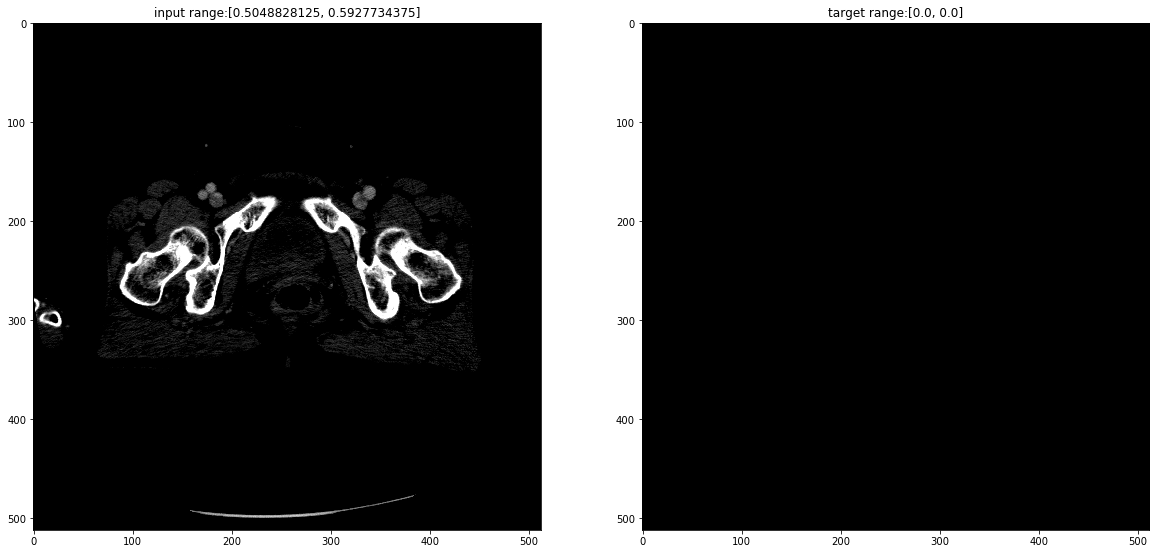

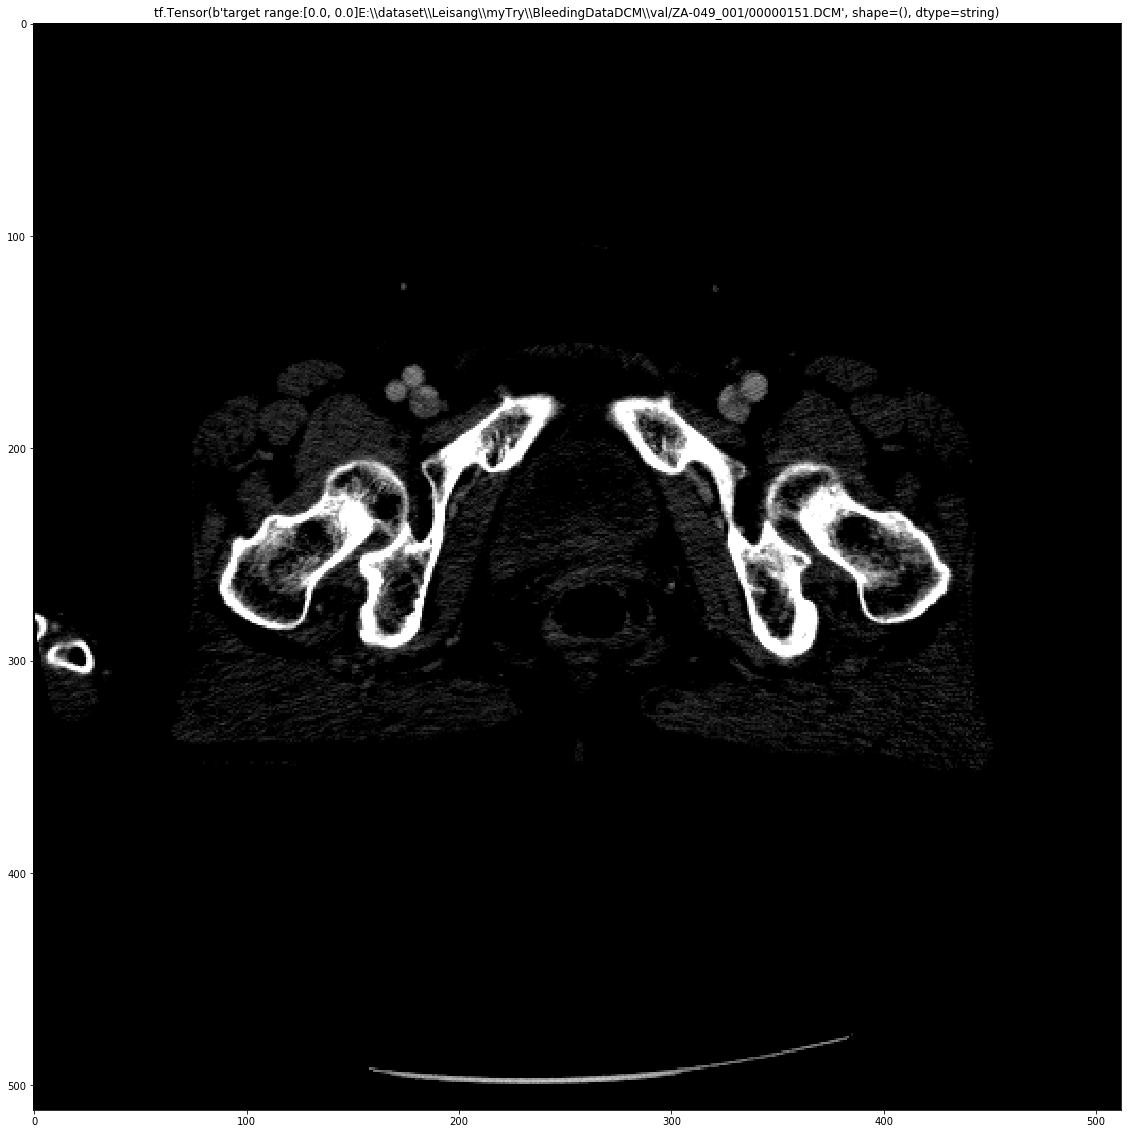

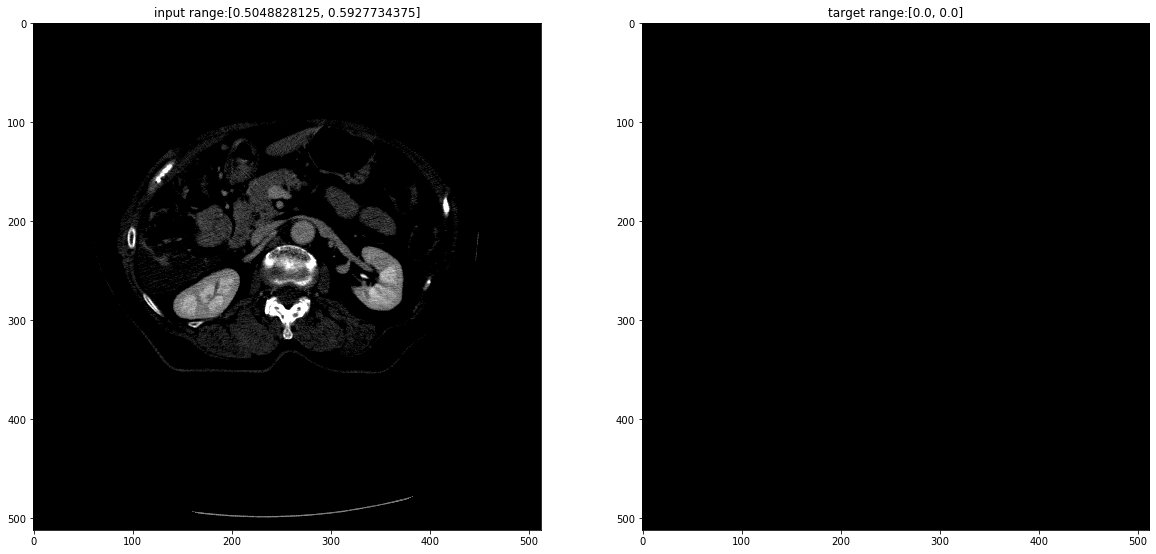

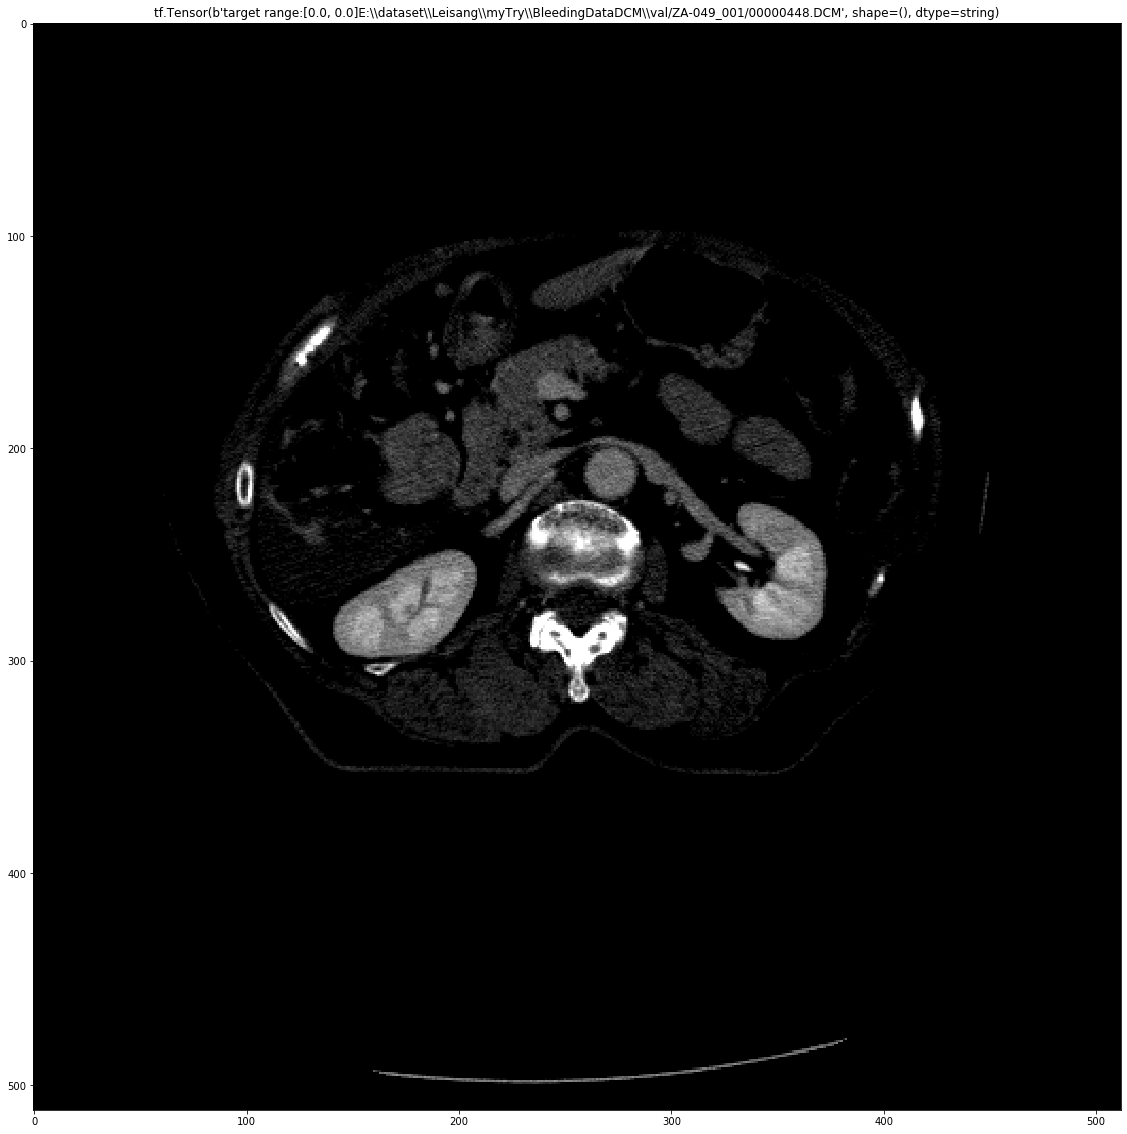

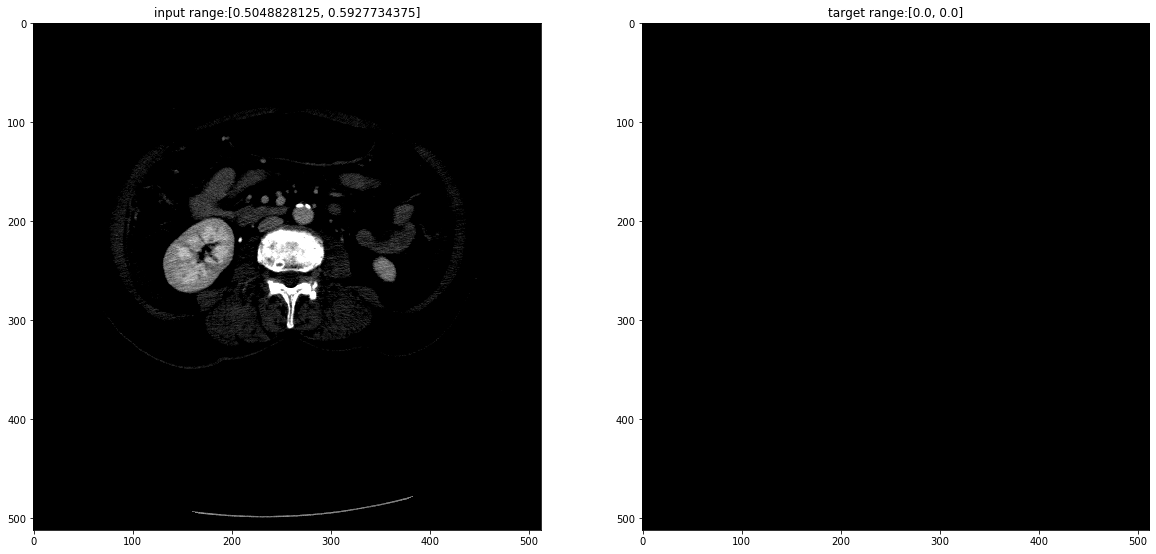

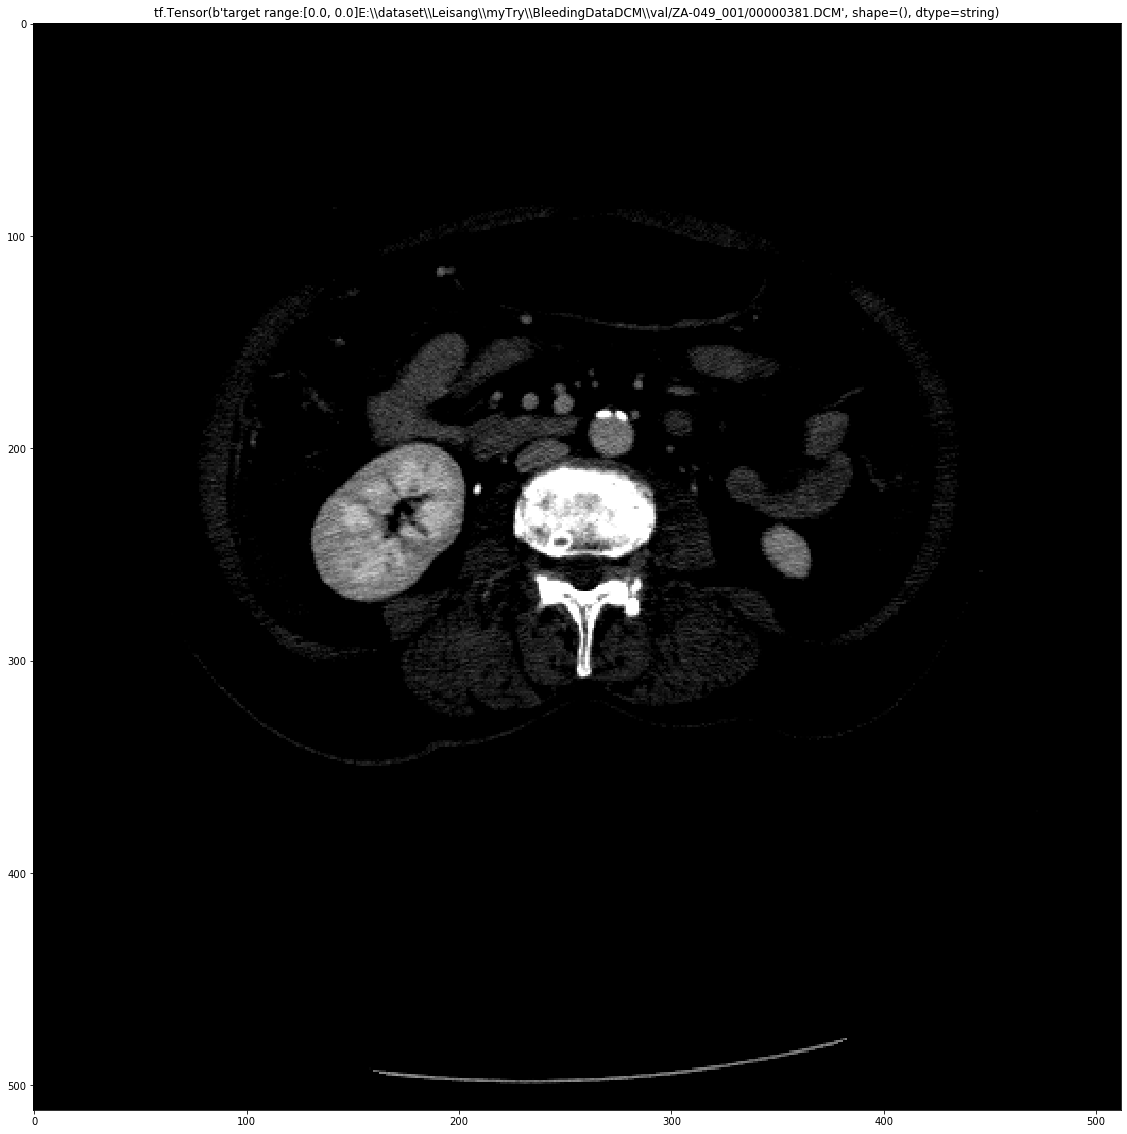

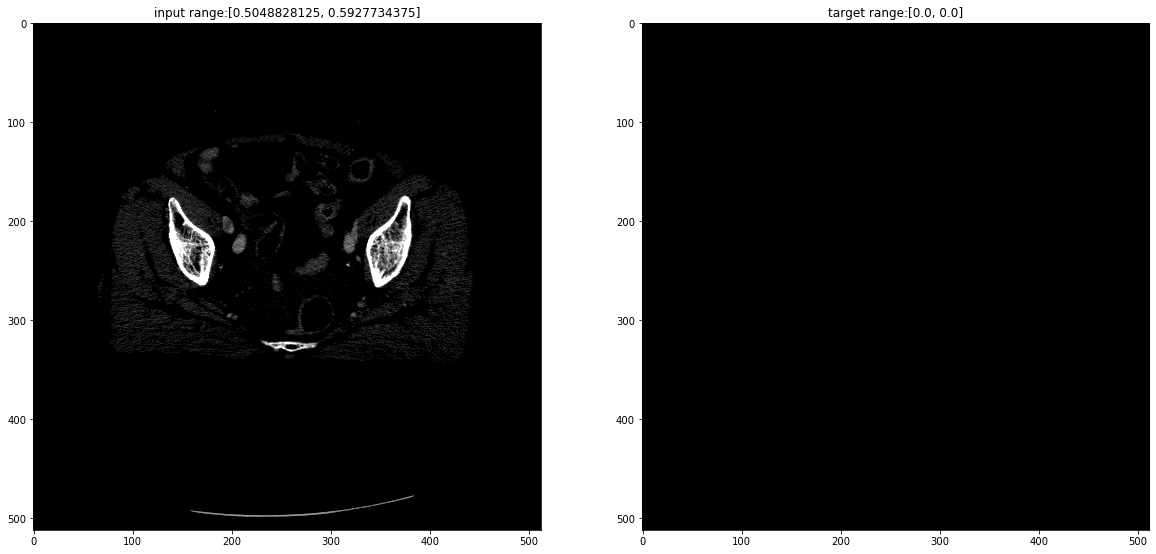

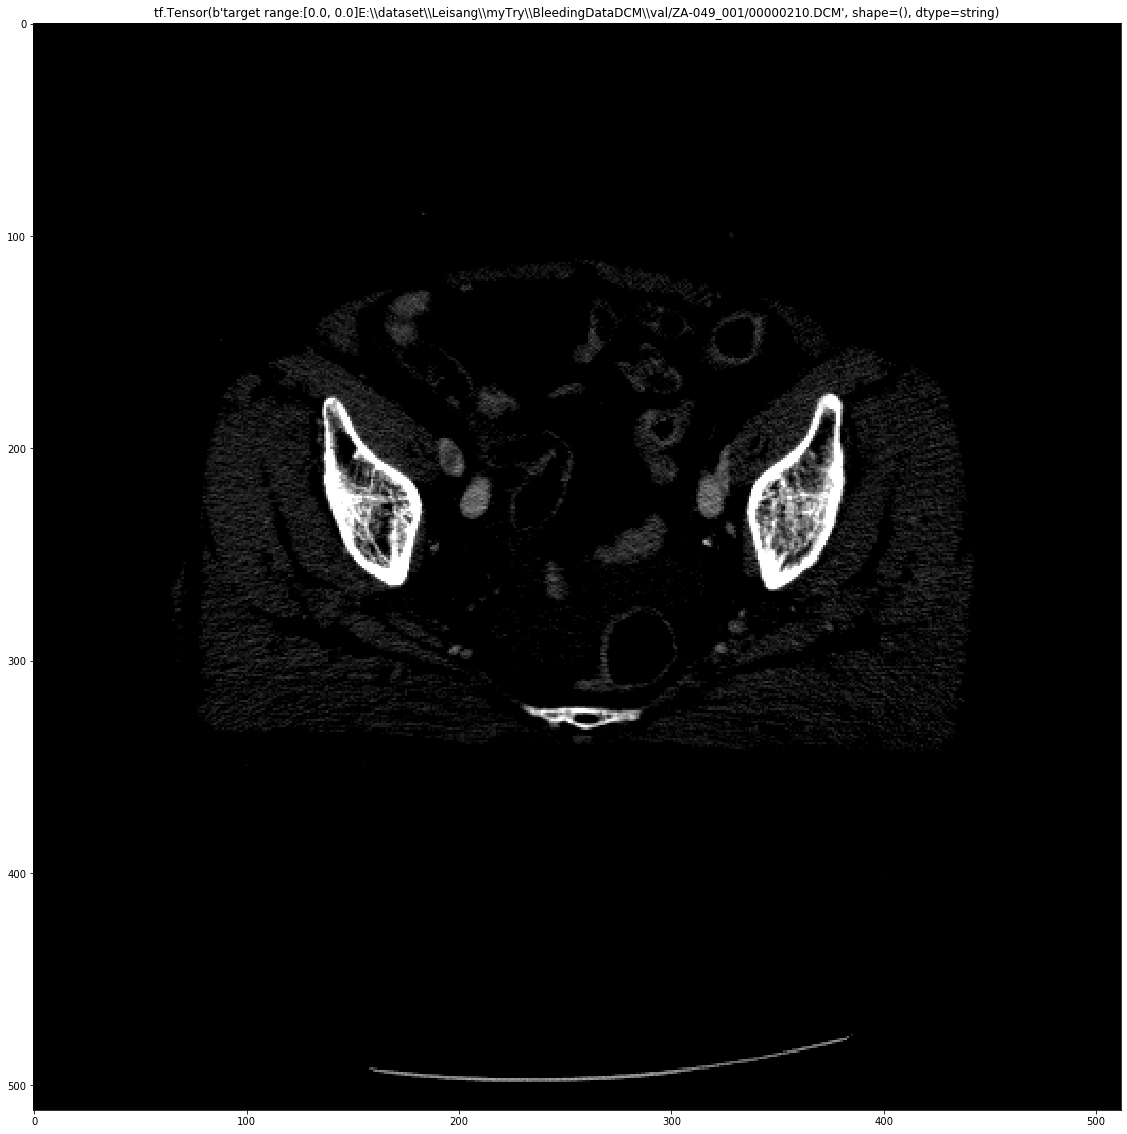

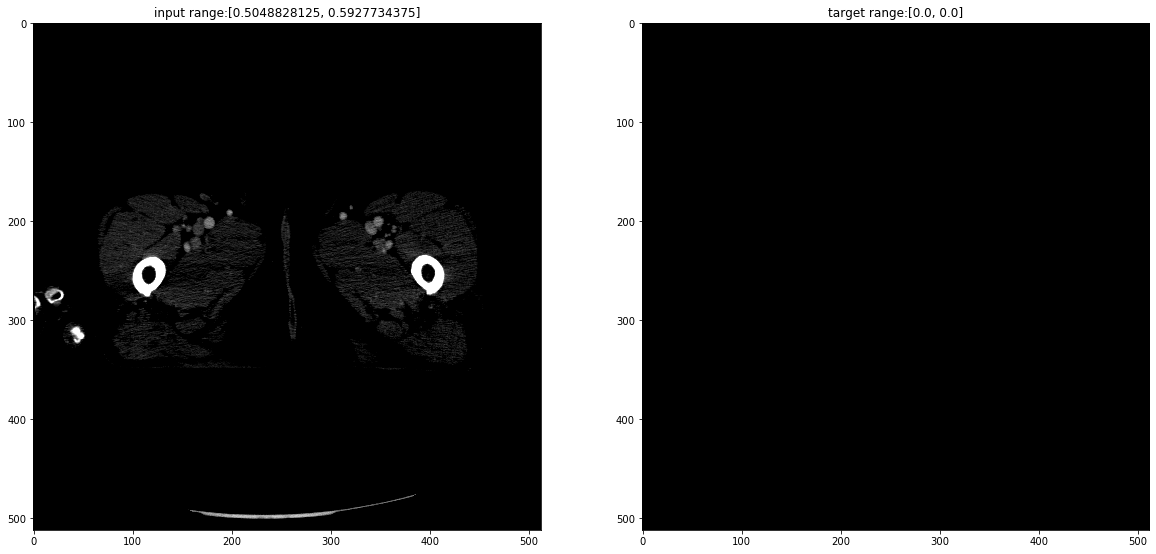

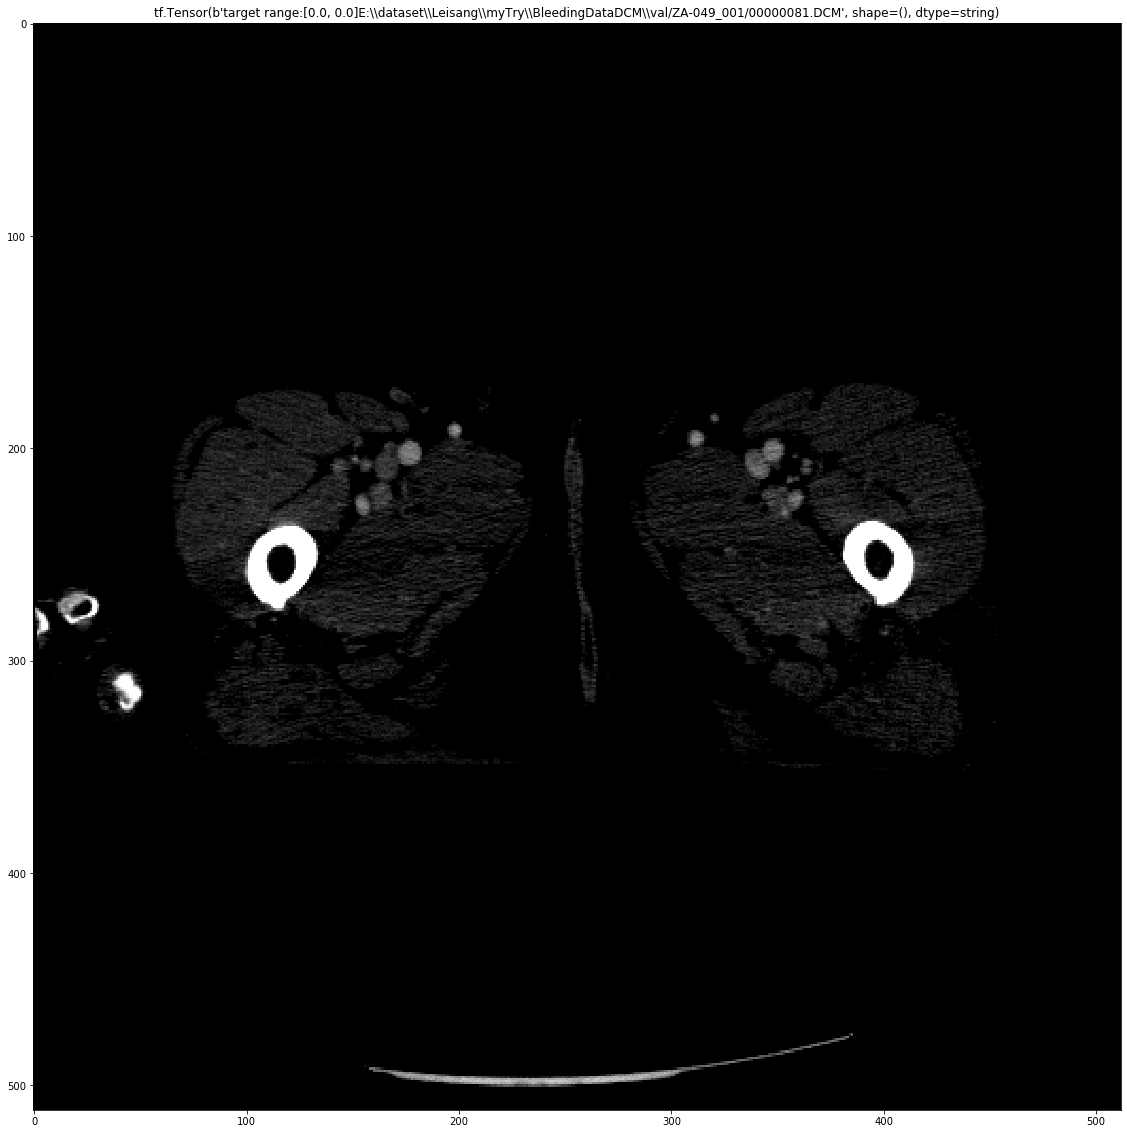

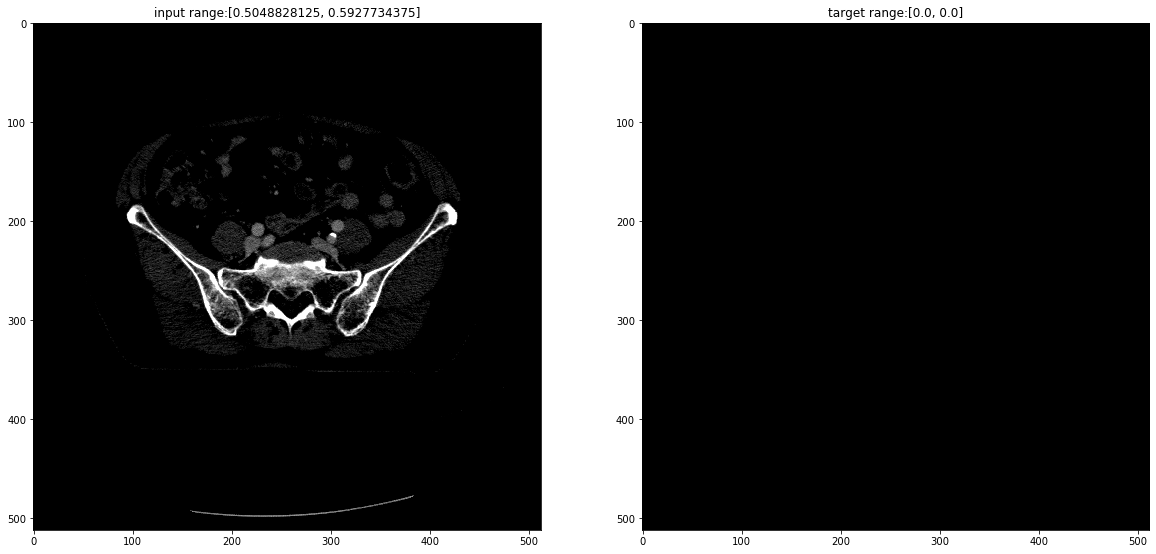

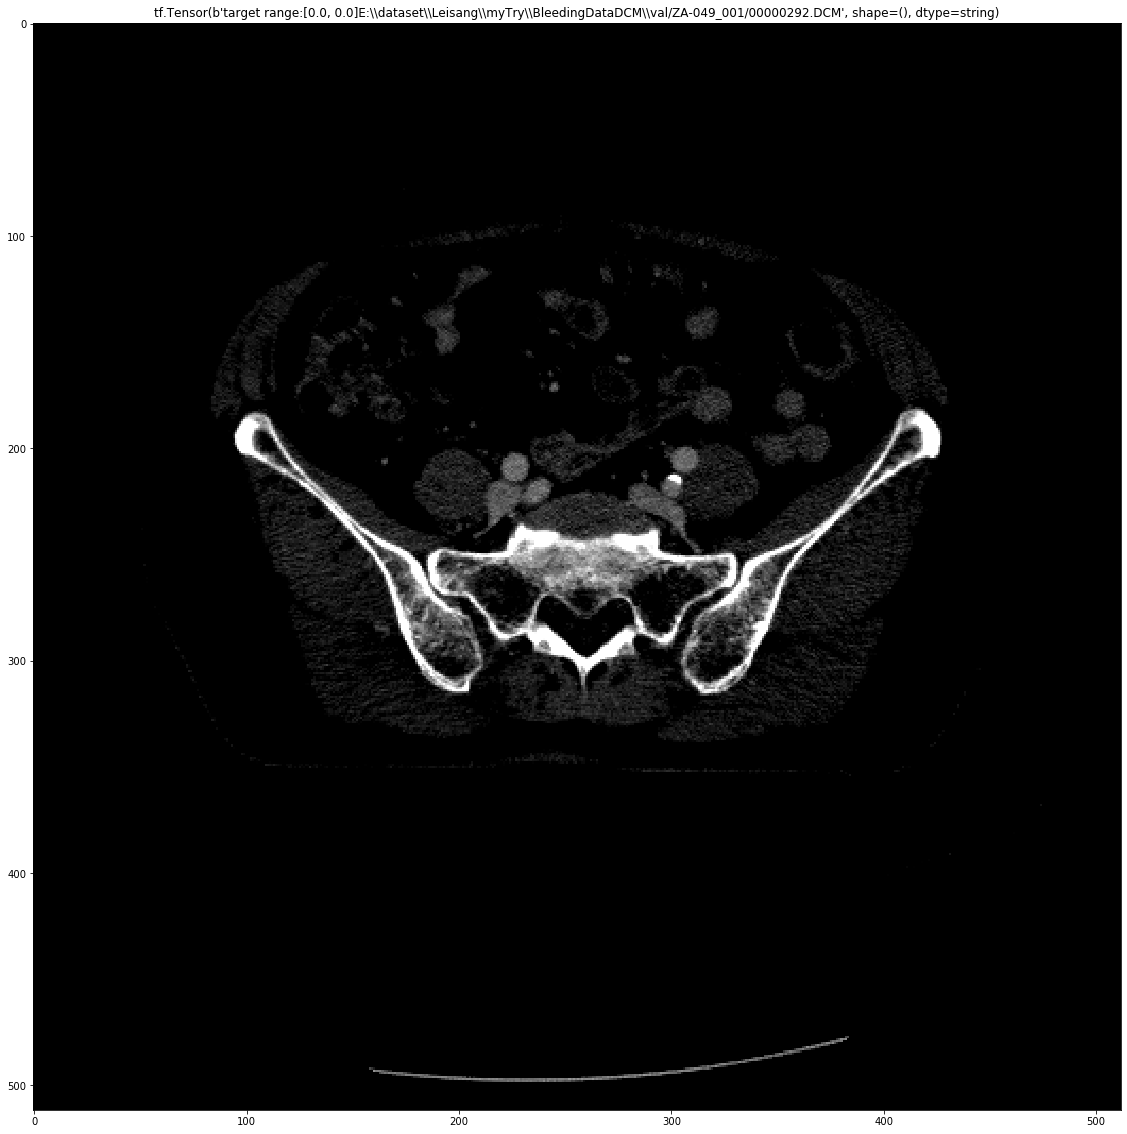

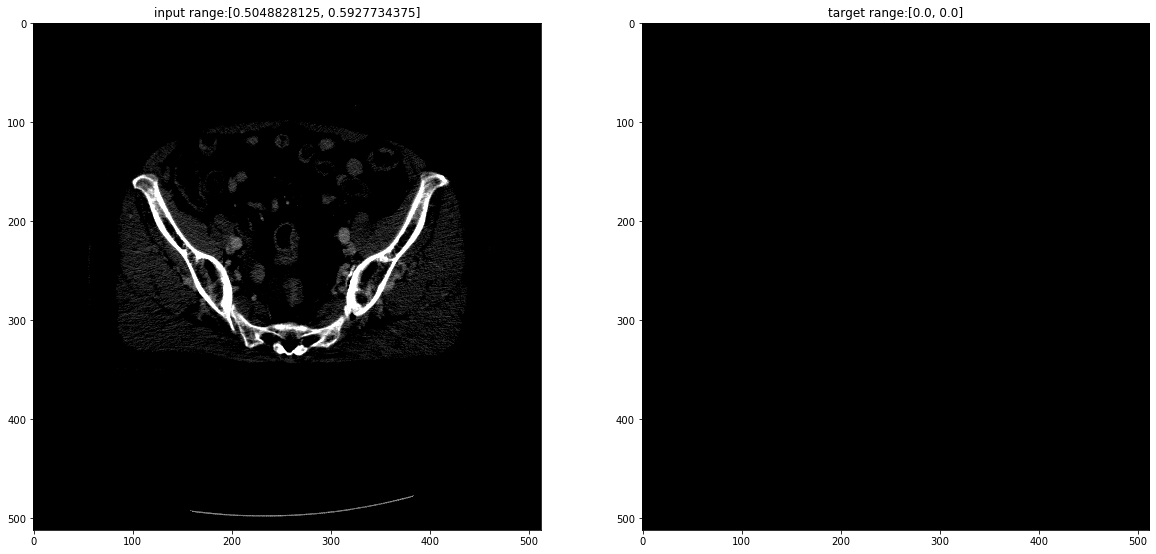

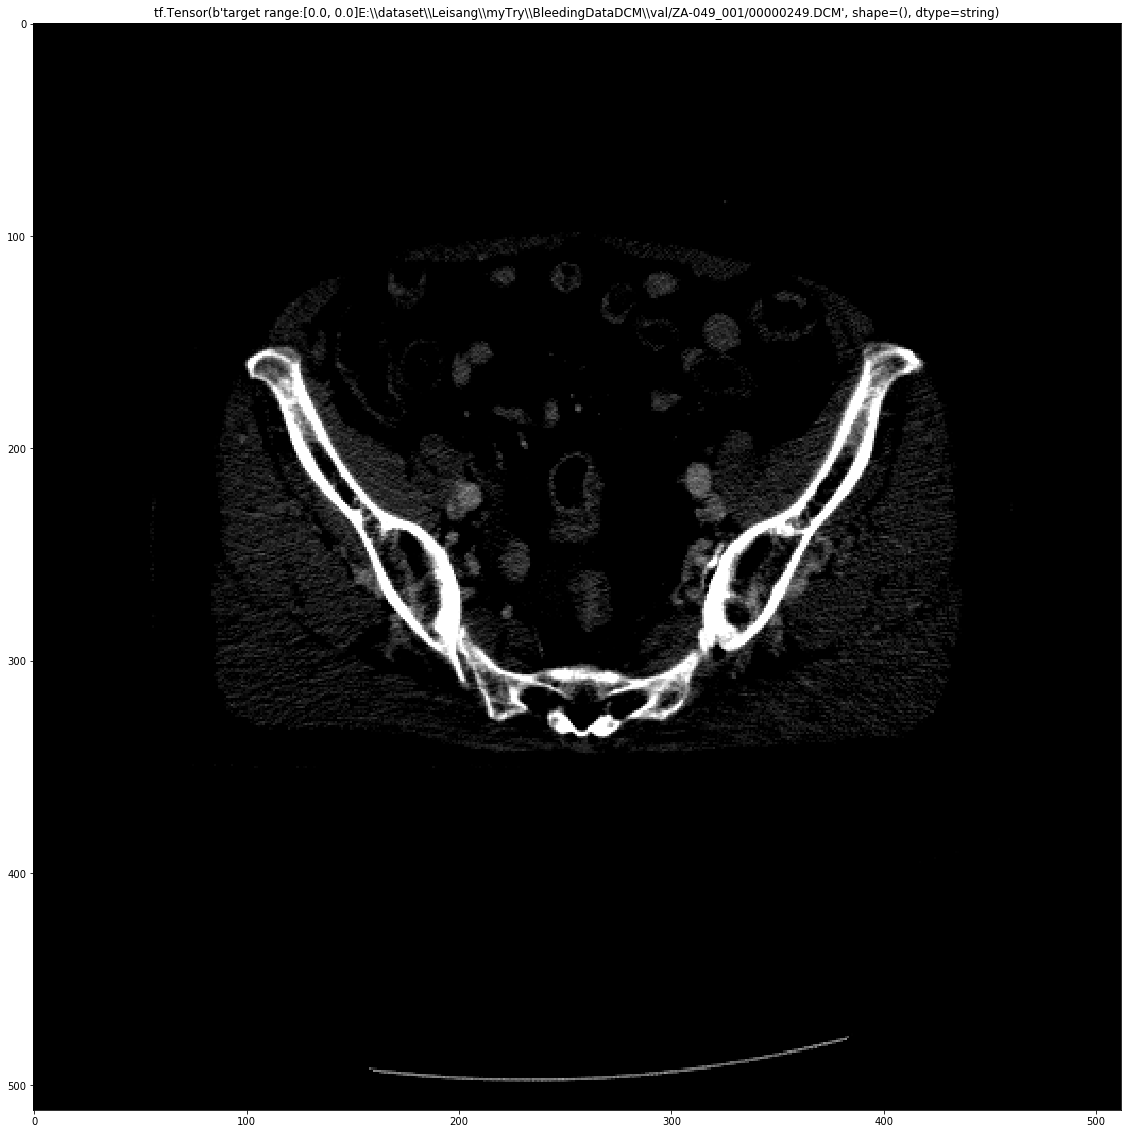

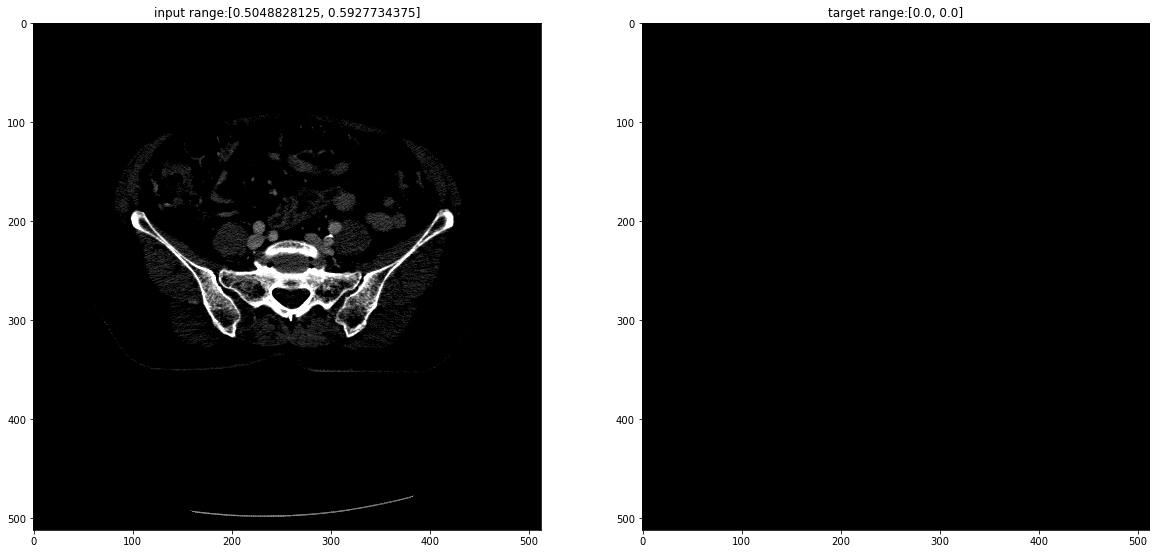

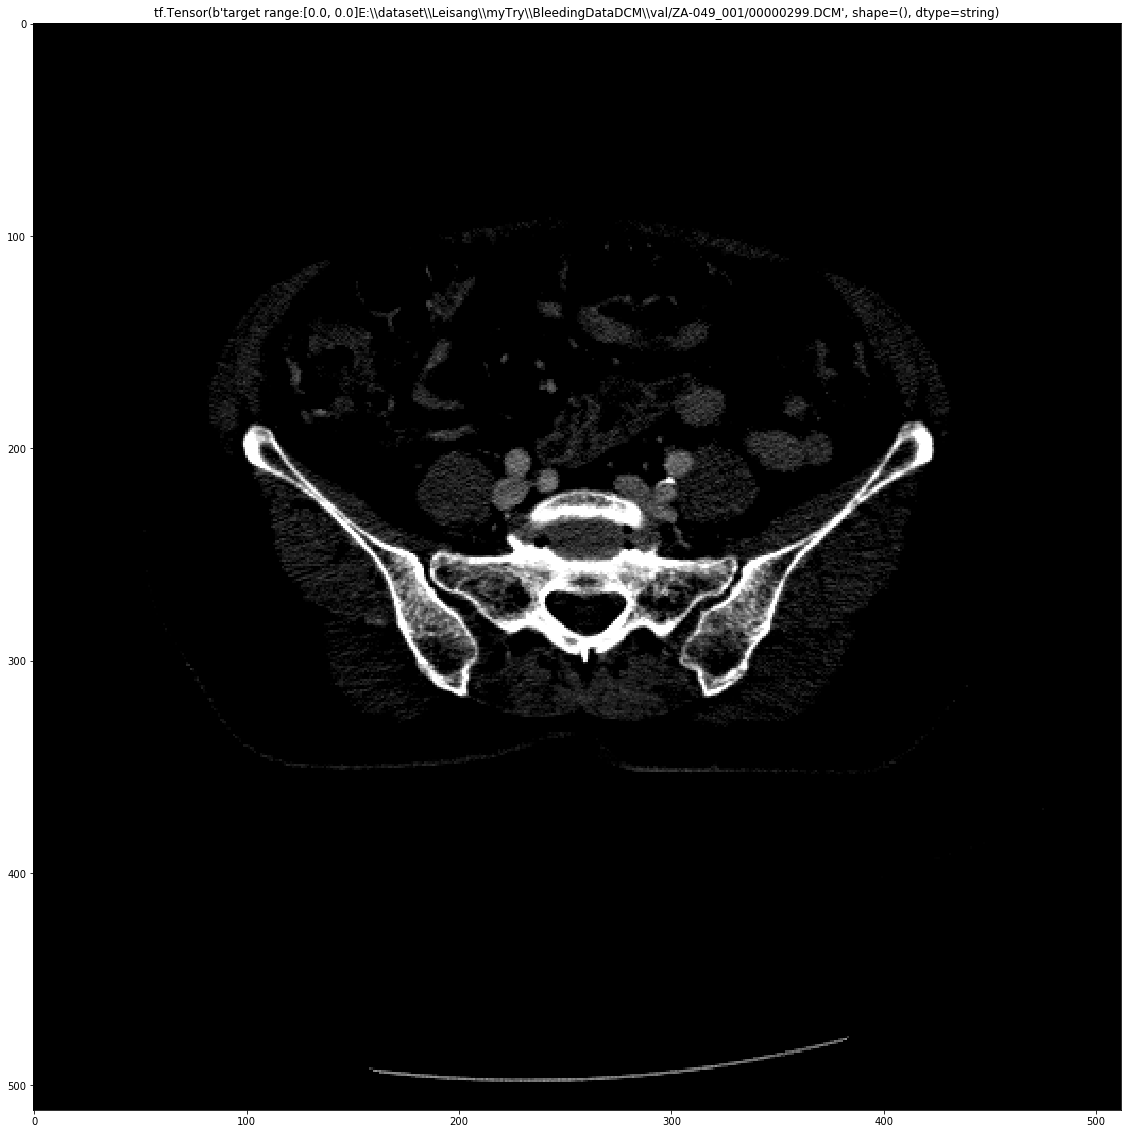

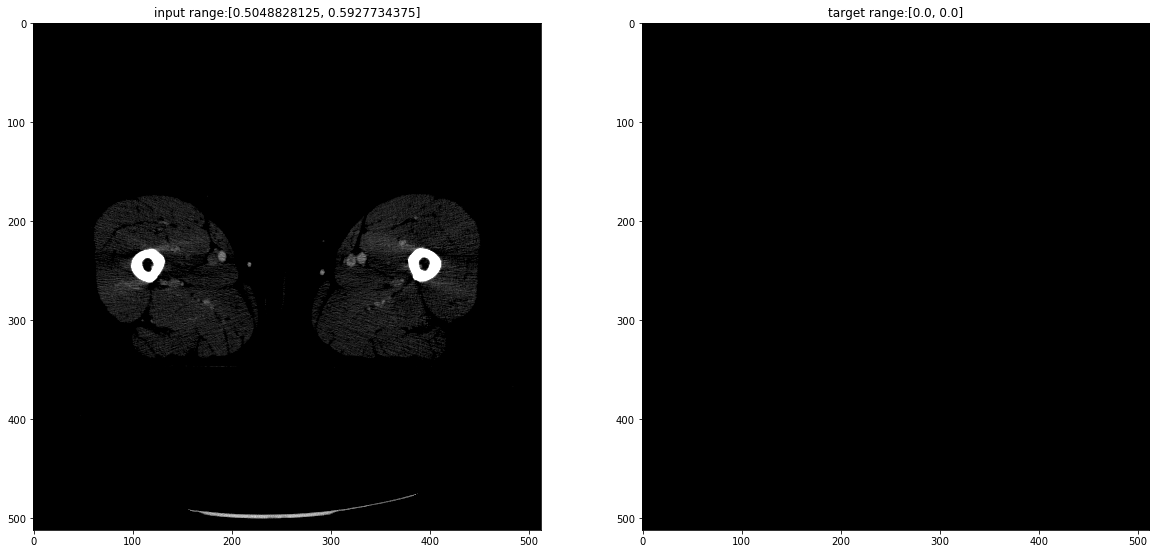

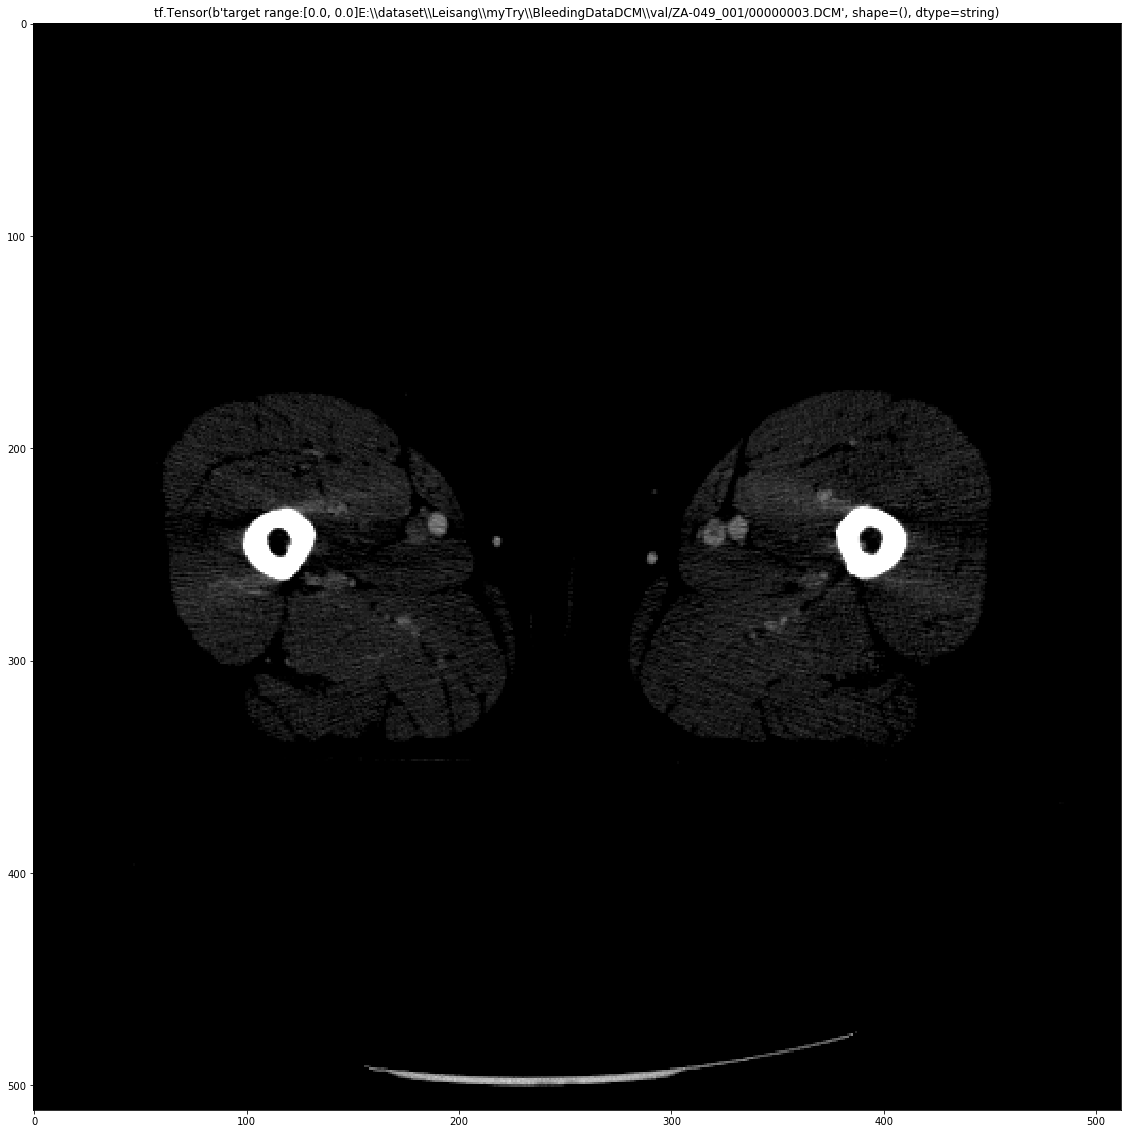

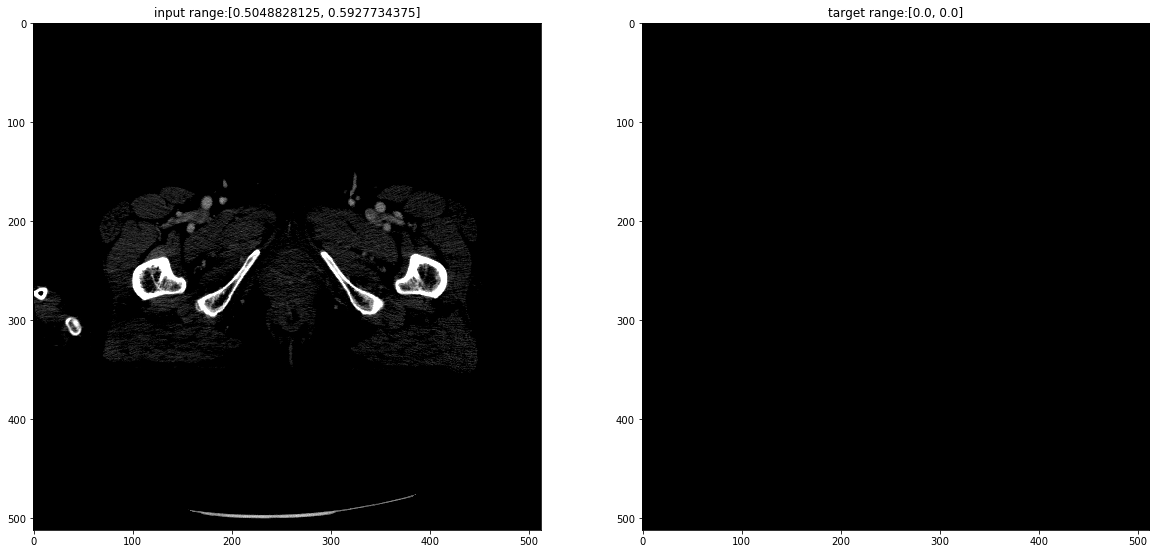

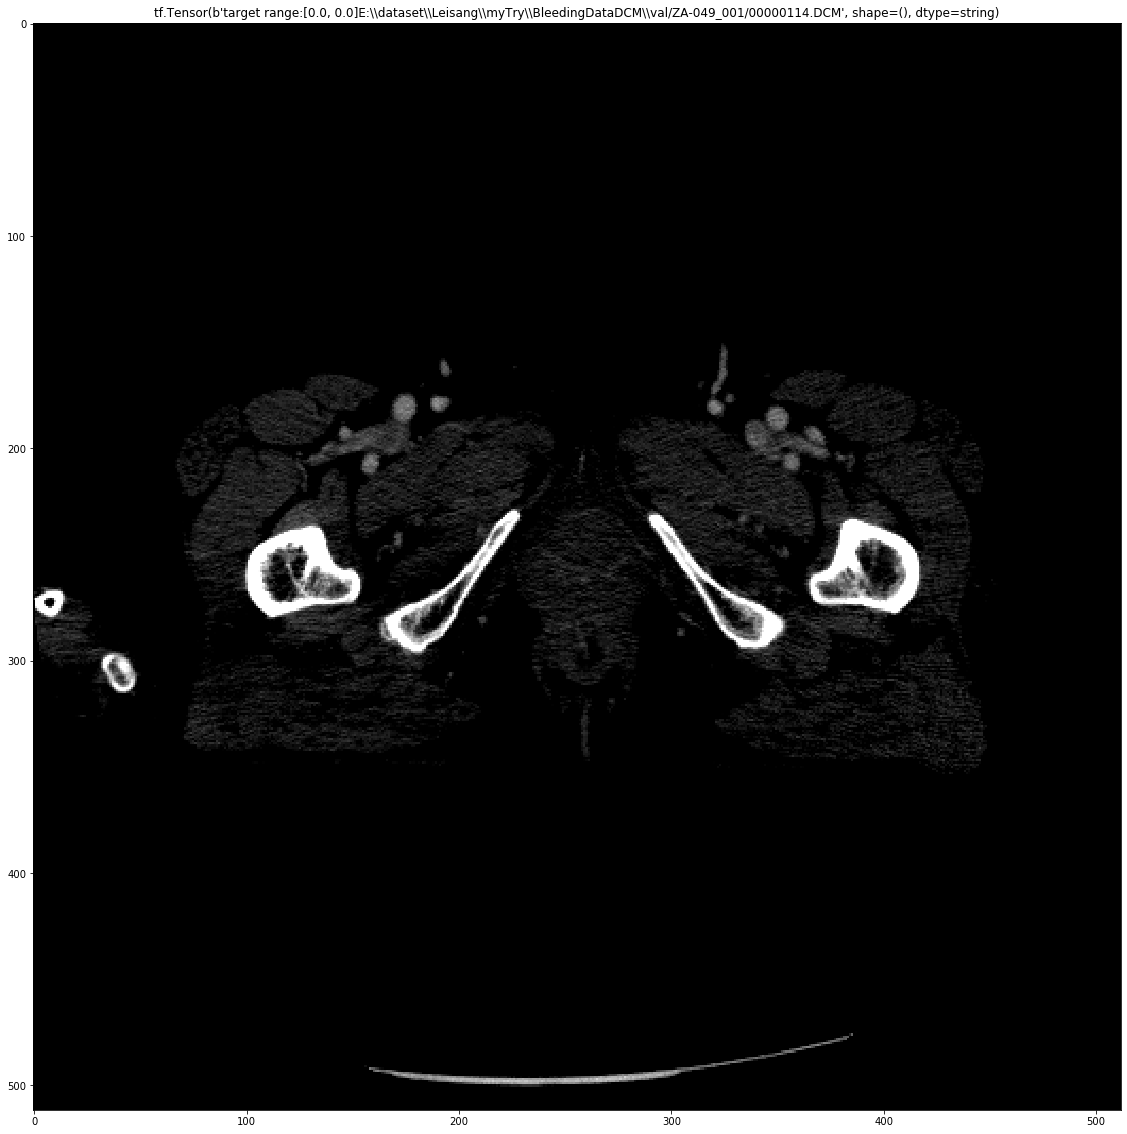

In [16]:


# Create a dictionary describing the features.
image_feature_description = {
        'dicom_path': tf.io.FixedLenFeature([], tf.string),
        'seg_label': tf.io.FixedLenFeature([], tf.string), 
        'cls_label': tf.io.FixedLenFeature([], tf.int64),
}


def _parse_image_function(example_proto):
    parsed_features = tf.io.parse_single_example(example_proto, image_feature_description)
    # Parse the input tf.Example proto using the dictionary above.
    
    
    # decode dicom
    dicom_path = parsed_features["dicom_path"]
    image_bytes = tf.io.read_file(dicom_path)
    input_image = tf.cast(tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16), tf.float32)
    # decode mask
    seg_label = tf.io.decode_raw(parsed_features['seg_label'], tf.uint8)
    return dicom_path, input_image, seg_label,  parsed_features["cls_label"]



def truncate(x, min, max):
#     print(x.shape)
    cliped =  tf.clip_by_value(x, min, max)
    return cliped
 
def norm(x, min, max):
    # normalize_value = (value − min_value) / (max_value − min_value)
    tensor = tf.math.divide(tf.subtract(x, min),
                    tf.subtract(max, min))
    return tensor

def linear_normalization(input, min=30720.0, max=34816.0):
    truncated_input = truncate(input, min, max)
    norm_input = norm(truncated_input, min, max )
    return  norm_input

def check_dataset(dataset):
    # window the input
    def winwise(input,LB,HB):
        # 20 ,380 for range (-32768, 32767)
        # for tf input , (0, 65535)-? LB =  32788, 33148
        input[input<LB] = LB # low boundary , if < LW , set to LW
        input[input>HB] = HB # high boundary, if > Hw, Set to 255
        return input

    # print(len(parsed_train_positive_dataset))
    BUFFER_SIZE =512
    # random shuffle the train positive dagtaset
    parsed_dataset = dataset.shuffle(BUFFER_SIZE)
    
    palette = copy(plt.cm.gray)
    palette.set_over('r', 1.0)
#     palette.set_under('g', 1.0)
#     palette.set_bad('b', 1.0)
        
    
    
    for image_features in parsed_dataset.take(10):
        dicom_path =  image_features[0]
        input =  image_features[1]
    #     dicom_path = image_features[0].numpy()
        target = image_features[2]
        cls_label = image_features[3]
        print("dicom_path:", dicom_path)
        print("input_image.shape", input.shape)
    #     print("dicom_path", dicom_path)
    #     print("dicom_path:", dicom_path)
        print("seg_label", target.shape)
        print("cls_label", cls_label)

        # reshape label 
        target =  tf.reshape(target, input.shape)
        fig, axes = plt.subplots(1,2, figsize=(20,20))

        #
        
        mask =  np.squeeze(target.numpy())
        norm_mask =mask/255
        input_arr = np.squeeze(winwise(input.numpy(), 32788,33148 ))
        norm_input = linear_normalization(input_arr)
        masked_in = norm_mask + norm_input
        print('masked_in range:[{}, {}]'.format((masked_in.numpy().min()), masked_in.numpy().max()))
        
        masked = np.ma.masked_where(norm_mask==0, masked_in)  # this is only generated mask
        print('masked range:[{}, {}]'.format(masked.min(), masked.max())) 
        print()
        axes[0].imshow(norm_input, cmap='gray')
        axes[0].set_title('input range:[{}, {}]'.format((norm_input.numpy().min()), np.max(norm_input.numpy())))
        axes[1].imshow(norm_mask, cmap='gray')
        axes[1].set_title('target range:[{}, {}]'.format(np.min(norm_mask), np.max(norm_mask)))
        
        fig2, axes2 = plt.subplots(1,1, figsize=(20,20))
        axes2.imshow(norm_input, cmap='gray')
        axes2.imshow(masked, palette, colors.Normalize(vmin=0, vmax=1), interpolation='none', alpha=0.4)
        axes2.set_title('target range:[{}, {}]'.format(np.min(masked), np.max(masked)) + dicom_path)
        
        print(dicom_path)

        
# check validation dataset
val_positive_dataset = tf.data.TFRecordDataset(val_positive_file_name)
val_negative_dataset = tf.data.TFRecordDataset(val_negative_file_name)
parsed_val_positive_dataset = val_positive_dataset.map(_parse_image_function)
parsed_val_negative_dataset = val_negative_dataset.map(_parse_image_function)

check_dataset(parsed_val_positive_dataset)
check_dataset(parsed_val_negative_dataset)